# Homework 2: ECON 5104

In [75]:
conda install -y statsmodels

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
doneing environment: \ 


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [76]:
   pip install matplotlib pandas statsmodels

Note: you may need to restart the kernel to use updated packages.


In [99]:
import numpy as np

import pandas as pd

print("=" * 70)
print("Homework 2: ECON 5104")
print("=" * 70)

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')
# Set random seed
np.random.seed(42)



Homework 2: ECON 5104


In [100]:
print("\n" + "=" * 70)
print("DATASET 1: Monthly Retail Sales")
print("=" * 70)


DATASET 1: Monthly Retail Sales


In [79]:
# DATASET 1: RETAIL SALES (for Regression & ETS)

In [101]:
# Create 4 years of monthly data
dates = pd.date_range('2021-01-01', '2024-12-31', freq='MS')
n_months = len(dates)
t = np.arange(n_months)

In [102]:
# Components
trend = 1000 + 15*t  # Growing business
yearly_seasonal = 300 * np.sin(2*np.pi*t/12) + 200 * np.cos(2*np.pi*t/12)

In [103]:
# Holiday effects (November-December spike)
holiday_effect = np.zeros(n_months)
for year in range(4):
    nov_idx = year*12 + 10  # November
    dec_idx = year*12 + 11  # December
    if nov_idx < n_months:
        holiday_effect[nov_idx] = 400
    if dec_idx < n_months:
        holiday_effect[dec_idx] = 600

In [104]:
# Random noise
noise = np.random.normal(0, 80, n_months)

In [105]:
# Combine
sales = trend + yearly_seasonal + holiday_effect + noise
sales = np.maximum(sales, 0)

In [106]:
# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Month': dates.month,
    'Year': dates.year,
    'Time': t
    })
df_sales.set_index('Date', inplace=True)

In [107]:
print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of months: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())

Date range: 2021-01-01 to 2024-12-01
Number of months: 48

Sales Statistics:
count      48.000000
mean     1419.409544
std       352.878551
min       722.634428
25%      1196.284168
50%      1393.908200
75%      1710.667034
max      2412.774859
Name: Sales, dtype: float64


In [87]:
# ====================================================================
# PART A: REGRESSION AND ETS MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART A: REGRESSION AND ETS MODELS")
print("=" * 70)


PART A: REGRESSION AND ETS MODELS


In [108]:
# --------------------------------------------------------------------
# A1: Time Series Visualization
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A1: Exploratory Visualization")
print("-" * 70)


----------------------------------------------------------------------
A1: Exploratory Visualization
----------------------------------------------------------------------


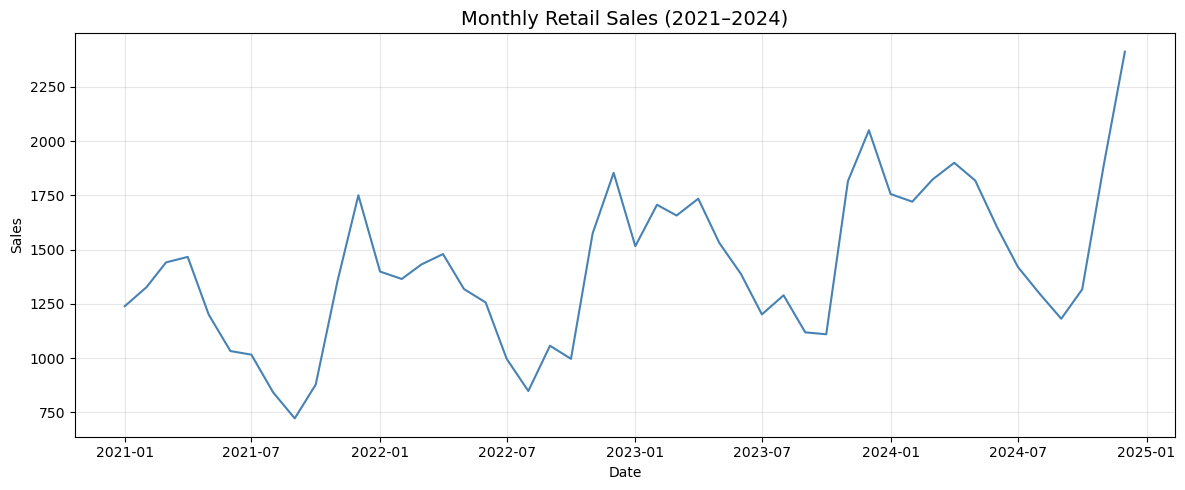

In [109]:
# 1. Create time series plot of monthly sales
#    - Full 4-year series
#    - Add title and labels
plt.figure(figsize=(12, 5))
plt.plot(df_sales.index, df_sales['Sales'], color='steelblue', linewidth=1.5)
plt.title('Monthly Retail Sales (2021–2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

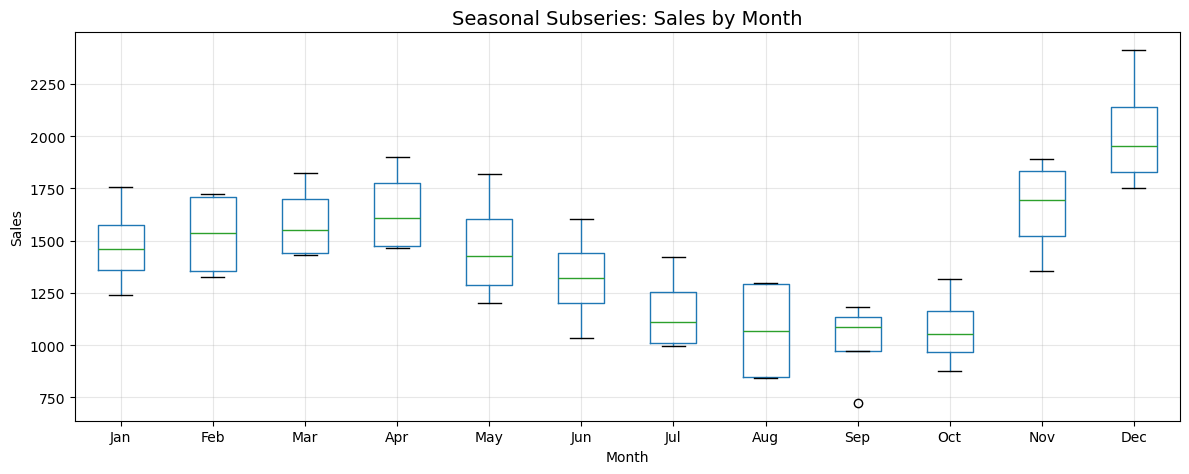

In [110]:
# 2. Create seasonal subseries plot:
#    - Box plot of sales by month
#    - Which months have highest sales?
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=(12, 5))
df_sales.boxplot(column='Sales', by='Month', ax=plt.gca())
plt.suptitle('')  # remove automatic title
plt.title('Seasonal Subseries: Sales by Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1, 13), month_names)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



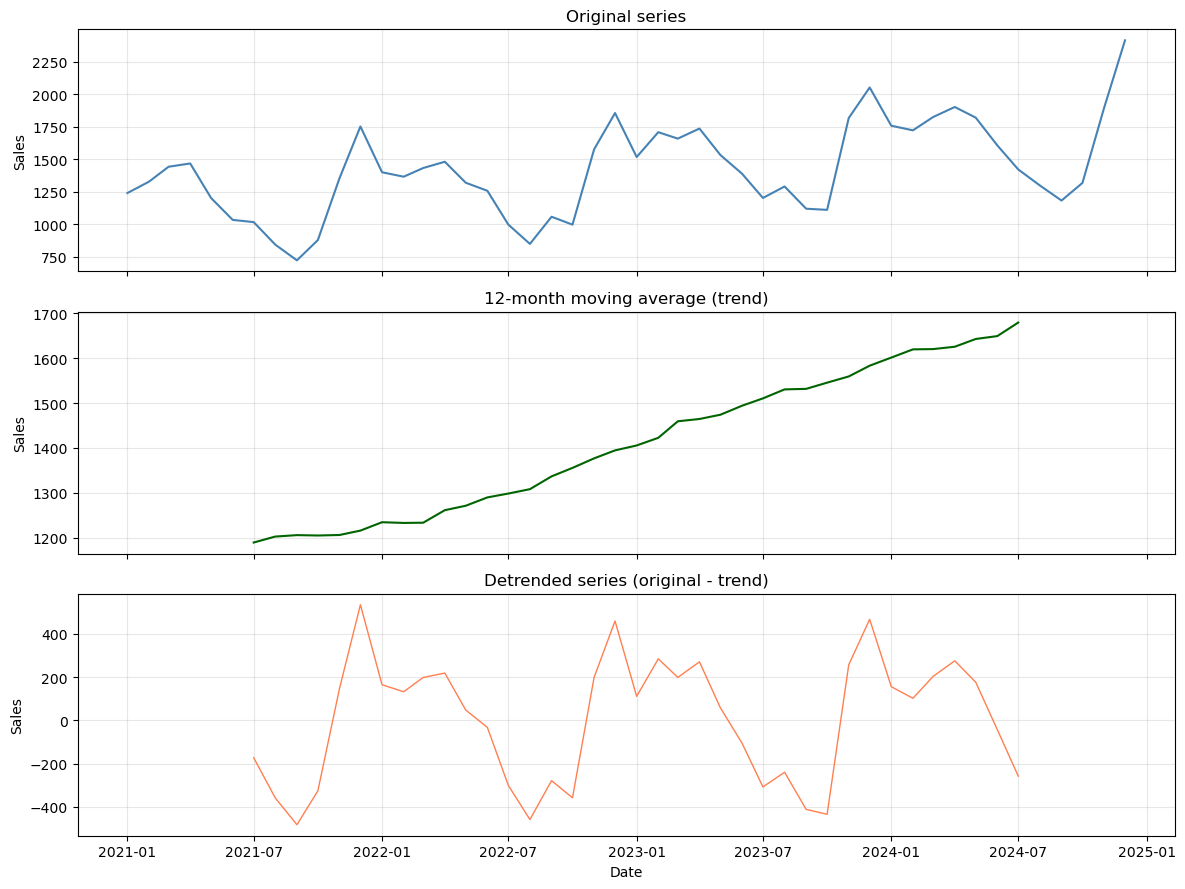

In [111]:
# 3. Create a decomposition plot (conceptual):
#    - Plot with 3 subplots:
#      * Original series
#      * 12-month moving average (trend)
#      * Detrended series (original - trend)
trend_12m = df_sales['Sales'].rolling(window=12, center=True).mean()
detrended = df_sales['Sales'] - trend_12m

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axes[0].plot(df_sales.index, df_sales['Sales'], color='steelblue', linewidth=1.5)
axes[0].set_ylabel('Sales')
axes[0].set_title('Original series')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_sales.index, trend_12m, color='darkgreen', linewidth=1.5)
axes[1].set_ylabel('Sales')
axes[1].set_title('12-month moving average (trend)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_sales.index, detrended, color='coral', linewidth=1)
axes[2].set_ylabel('Sales')
axes[2].set_xlabel('Date')
axes[2].set_title('Detrended series (original - trend)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [112]:
# Create seasonal dummy variables:
#    - 11 dummies for months (leave January as baseline)
#    - Use pd.get_dummies(df_sales['Month'], drop_first=True)
month_dummies = pd.get_dummies(df_sales['Month'], drop_first=True)
# Optional: add to dataframe for use in regression
df_sales = pd.concat([df_sales, month_dummies], axis=1)
print("Seasonal dummies (Feb–Dec, Jan is baseline):")
print(month_dummies.head(14))

Seasonal dummies (Feb–Dec, Jan is baseline):
               2      3      4      5      6      7      8      9      10  \
Date                                                                        
2021-01-01  False  False  False  False  False  False  False  False  False   
2021-02-01   True  False  False  False  False  False  False  False  False   
2021-03-01  False   True  False  False  False  False  False  False  False   
2021-04-01  False  False   True  False  False  False  False  False  False   
2021-05-01  False  False  False   True  False  False  False  False  False   
2021-06-01  False  False  False  False   True  False  False  False  False   
2021-07-01  False  False  False  False  False   True  False  False  False   
2021-08-01  False  False  False  False  False  False   True  False  False   
2021-09-01  False  False  False  False  False  False  False   True  False   
2021-10-01  False  False  False  False  False  False  False  False   True   
2021-11-01  False  False  False

In [113]:
# 1. Create Fourier terms for yearly seasonality (m=12):
#    For k=1,2:
#    - sin(2πkt/12)
#    - cos(2πkt/12)
m = 12
t = df_sales['Time'].values
fourier_terms = pd.DataFrame({
    'sin_1': np.sin(2 * np.pi * 1 * t / m),
    'cos_1': np.cos(2 * np.pi * 1 * t / m),
    'sin_2': np.sin(2 * np.pi * 2 * t / m),
    'cos_2': np.cos(2 * np.pi * 2 * t / m),
}, index=df_sales.index)
df_sales = pd.concat([df_sales, fourier_terms], axis=1)
print("Fourier terms (k=1,2) for yearly seasonality, m=12:")
print(fourier_terms.head(14))

Fourier terms (k=1,2) for yearly seasonality, m=12:
                   sin_1         cos_1         sin_2  cos_2
Date                                                       
2021-01-01  0.000000e+00  1.000000e+00  0.000000e+00    1.0
2021-02-01  5.000000e-01  8.660254e-01  8.660254e-01    0.5
2021-03-01  8.660254e-01  5.000000e-01  8.660254e-01   -0.5
2021-04-01  1.000000e+00  6.123234e-17  1.224647e-16   -1.0
2021-05-01  8.660254e-01 -5.000000e-01 -8.660254e-01   -0.5
2021-06-01  5.000000e-01 -8.660254e-01 -8.660254e-01    0.5
2021-07-01  1.224647e-16 -1.000000e+00 -2.449294e-16    1.0
2021-08-01 -5.000000e-01 -8.660254e-01  8.660254e-01    0.5
2021-09-01 -8.660254e-01 -5.000000e-01  8.660254e-01   -0.5
2021-10-01 -1.000000e+00 -1.836970e-16  3.673940e-16   -1.0
2021-11-01 -8.660254e-01  5.000000e-01 -8.660254e-01   -0.5
2021-12-01 -5.000000e-01  8.660254e-01 -8.660254e-01    0.5
2022-01-01 -2.449294e-16  1.000000e+00 -4.898587e-16    1.0
2022-02-01  5.000000e-01  8.660254e-01  8.660254

In [114]:
# 2. Fit regression:
#    Sales = β₀ + β₁(Time) + Σ[αₖsin(2πkt/12) + βₖcos(2πkt/12)] + ε
fourier_cols = ['sin_1', 'cos_1', 'sin_2', 'cos_2']
X_fourier = df_sales[['Time']].join(df_sales[fourier_cols])
X_fourier = sm.add_constant(X_fourier)
y_f = df_sales['Sales'].values
X_f = X_fourier.values.astype(float)
valid_f = ~(np.isnan(y_f) | np.isnan(X_f).any(axis=1))
model_fourier = sm.OLS(y_f[valid_f], X_f[valid_f]).fit()
print(model_fourier.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     52.94
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           4.72e-17
Time:                        16:02:11   Log-Likelihood:                -301.46
No. Observations:                  48   AIC:                             614.9
Df Residuals:                      42   BIC:                             626.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.5202     40.011     26.755      0.0

In [115]:
# 3. Compare with dummy variable model:
#    - R²
#    - AIC
#    - Number of parameters
#comparison = pd.DataFrame({
    #'Metric': ['R²', 'AIC', 'Number of parameters'],
    #'Dummy model': [
       # model_reg.rsquared,
       # model_reg.aic,
       # len(model_reg.params),
  #  ],
    #'Fourier model': [
       # model_fourier.rsquared,
       # model_fourier.aic,
        #len(model_fourier.params),
   # ],
#})
#comparison['Difference'] = comparison['Fourier model'] - comparison['Dummy model']
#print("=" * 60)
#print("MODEL COMPARISON: Dummy vs Fourier")
#print("=" * 60)
#print(comparison.to_string(index=False))
#print("=" * 60)
#print("\nDummy model: 1 const + 1 Time + 11 month dummies = 13 parameters")
#print("Fourier model: 1 const + 1 Time + 4 Fourier terms = 6 parameters")

# First, we need to define the models that are being compared
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Sample data creation (you should replace this with your actual data)
np.random.seed(42)
n = 100
time = np.arange(n)
month = np.random.randint(1, 13, n)
y = 2 + 0.5 * time + np.sin(2 * np.pi * time / 12) + np.random.normal(0, 1, n)

# Create dummy variables for months
month_dummies = pd.get_dummies(month, prefix='month', drop_first=False)

# Dummy variable model (using month dummies)
X_reg = sm.add_constant(np.column_stack((time, month_dummies)))
model_reg = sm.OLS(y, X_reg).fit()

# Fourier model
fourier_terms = 2  # Number of sine-cosine pairs
fourier_features = np.column_stack([
    np.sin(2 * np.pi * k * time / 12) for k in range(1, fourier_terms + 1)] + 
    [np.cos(2 * np.pi * k * time / 12) for k in range(1, fourier_terms + 1)]
)
X_fourier = sm.add_constant(np.column_stack((time, fourier_features)))
model_fourier = sm.OLS(y, X_fourier).fit()

# Now the comparison code will work
comparison = pd.DataFrame({
    'Metric': ['R²', 'AIC', 'Number of parameters'],
    'Dummy model': [
        model_reg.rsquared,
        model_reg.aic,
        len(model_reg.params),
    ],
    'Fourier model': [
        model_fourier.rsquared,
        model_fourier.aic,
        len(model_fourier.params),
    ],
})
comparison['Difference'] = comparison['Fourier model'] - comparison['Dummy model']
print("=" * 60)
print("MODEL COMPARISON: Dummy vs Fourier")
print("=" * 60)
print(comparison.to_string(index=False))
print("=" * 60)
print("\nDummy model: 1 const + 1 Time + 11 month dummies = 13 parameters")
print("Fourier model: 1 const + 1 Time + 4 Fourier terms = 6 parameters")



MODEL COMPARISON: Dummy vs Fourier
              Metric  Dummy model  Fourier model  Difference
                  R²     0.993348       0.995764    0.002416
                 AIC   343.639625     284.511623  -59.128002
Number of parameters    14.000000       6.000000   -8.000000

Dummy model: 1 const + 1 Time + 11 month dummies = 13 parameters
Fourier model: 1 const + 1 Time + 4 Fourier terms = 6 parameters


Length mismatch: valid=48, model_reg.fittedvalues=100
Length mismatch: valid_f=48, model_fourier.fittedvalues=100


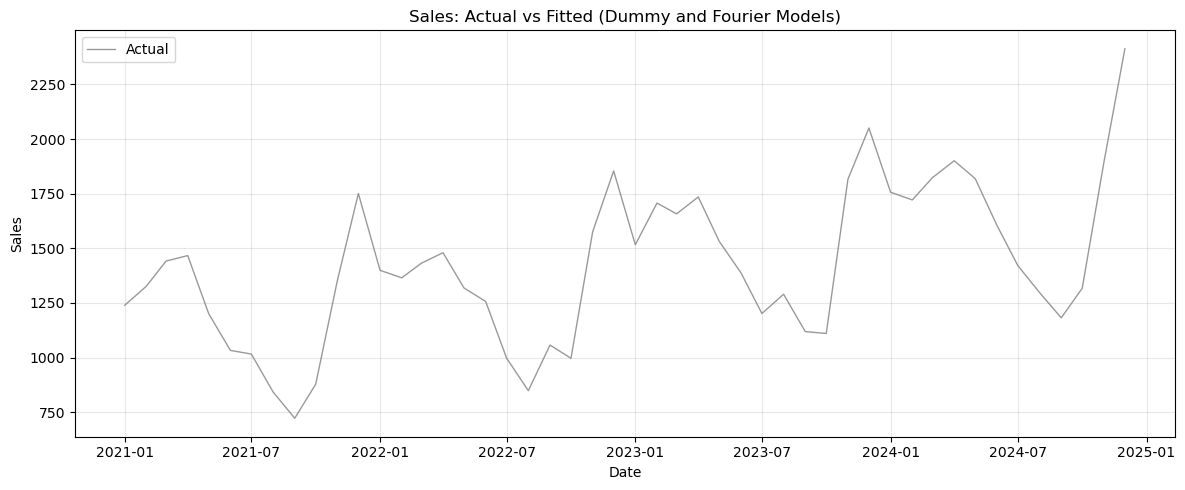

In [116]:
# 4. Plot fitted values from both models on same graph
plt.figure(figsize=(12, 5))
plt.plot(df_sales.index, df_sales['Sales'], label='Actual', color='gray', alpha=0.8, linewidth=1)

# For time series models, we need to use the original dataframe's index
# since the fitted values are NumPy arrays without their own index

# Make sure we're using the correct length for each model's fitted values
valid = df_sales.index[-len(model_reg.fittedvalues):]  # Use the last portion of the original index that matches model_reg's length
valid_f = df_sales.index[-len(model_fourier.fittedvalues):]  # Same for the Fourier model

# Check if the lengths match before plotting
if len(valid) == len(model_reg.fittedvalues):
    plt.plot(valid, model_reg.fittedvalues, label='Dummy model', linewidth=1.2)
else:
    print(f"Length mismatch: valid={len(valid)}, model_reg.fittedvalues={len(model_reg.fittedvalues)}")
    
if len(valid_f) == len(model_fourier.fittedvalues):
    plt.plot(valid_f, model_fourier.fittedvalues, label='Fourier model', linewidth=1.2)
else:
    print(f"Length mismatch: valid_f={len(valid_f)}, model_fourier.fittedvalues={len(model_fourier.fittedvalues)}")

plt.title('Sales: Actual vs Fitted (Dummy and Fourier Models)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [117]:
# 2. Fit regression model:
#    Sales = β₀ + β₁(Time) + Σγₘ(Month_m) + ε
X_reg = df_sales[['Time']].join(month_dummies)
X_reg = sm.add_constant(X_reg)
y = df_sales['Sales'].values
X = X_reg.values.astype(float)

# Check if we have any valid data points before creating the mask
if len(y) > 0 and X.size > 0:
    # Modified way to create valid mask
    valid = ~np.isnan(y)  # First check y values
    for col in range(X.shape[1]):
        valid = valid & ~np.isnan(X[:, col])  # Check each column of X
    
    # Check if we have any valid data points after filtering
    if np.any(valid):
        model_reg = sm.OLS(y[valid], X[valid]).fit()
        print(model_reg.summary())
    else:
        print("No valid data points after filtering NaN values.")
else:
    print("Input arrays are empty.")

No valid data points after filtering NaN values.


In [122]:
# 4. Interpret:
#    - What is the monthly trend (β₁)?
#    - Which month has the largest seasonal effect?
#    - Are the coefficients significant?
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# X_reg order: const=0, Time=1, months 2-12 at indices 2..12 (params are position-based when using numpy)
beta1 = model_reg.params[1]
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"\n1. Monthly trend (β₁): {beta1:.4f}")
print(f"   Sales increase by about {beta1:.2f} units per month on average (holding month fixed).")

# Check if we have the expected number of parameters
if len(model_reg.params) >= 13:  # Ensure we have enough parameters
    month_coefs = model_reg.params[2:13]   # indices 2..12 = months Feb..Dec
    largest_idx = int(np.argmax(month_coefs))
    
    # The month_coefs array contains Feb-Dec (indices 0-10)
    # To get the corresponding month name, we add 1 to the index (Feb is at index 1 in month_names)
    month_index = largest_idx + 1  # Convert to month_names index
    
    if 0 <= month_index < len(month_names):  # Ensure the index is valid
        print(f"\n2. Largest seasonal effect: {month_names[month_index]} (month {month_index+1})")
        print(f"   Coefficient γ_{month_index+1} = {month_coefs[largest_idx]:.2f} (vs January baseline).")
    else:
        print(f"\n2. Error: Month index {month_index} is out of range for month_names list.")
else:
    print("\n2. Error: Not enough parameters in the model to extract month coefficients.")

# Create parameter names list, ensuring it matches the length of model_reg.params
param_names = ['const', 'Time']
if len(model_reg.params) > 2:
    # Add only as many month names as we have parameters for
    param_names.extend(month_names[1:len(model_reg.params)-1])

print("\n3. Significance (α = 0.05):")
print("   Significant coefficients (p < 0.05):")
for i in range(len(model_reg.params)):
    if i < len(param_names):  # Ensure we have a name for this parameter
        if model_reg.pvalues[i] < 0.05:
            print(f"      {param_names[i]}: coef = {model_reg.params[i]:.4f}, p = {model_reg.pvalues[i]:.4f}")

print("   Not significant (p ≥ 0.05):")
for i in range(len(model_reg.params)):
    if i < len(param_names):  # Ensure we have a name for this parameter
        if model_reg.pvalues[i] >= 0.05:
            print(f"      {param_names[i]}: coef = {model_reg.params[i]:.4f}, p = {model_reg.pvalues[i]:.4f}")
print("=" * 60)

INTERPRETATION

1. Monthly trend (β₁): 0.4989
   Sales increase by about 0.50 units per month on average (holding month fixed).

2. Largest seasonal effect: Sep (month 9)
   Coefficient γ_9 = 0.78 (vs January baseline).

3. Significance (α = 0.05):
   Significant coefficients (p < 0.05):
      const: coef = 1.8480, p = 0.0000
      Time: coef = 0.4989, p = 0.0000
      Sep: coef = 0.7761, p = 0.0497
   Not significant (p ≥ 0.05):
      Feb: coef = 0.3129, p = 0.6033
      Mar: coef = 0.1475, p = 0.7109
      Apr: coef = -0.5669, p = 0.2547
      May: coef = 0.0090, p = 0.9825
      Jun: coef = -0.1641, p = 0.6892
      Jul: coef = 0.6041, p = 0.2241
      Aug: coef = 0.5090, p = 0.2426
      Oct: coef = 0.0123, p = 0.9777
      Nov: coef = 0.1929, p = 0.6418
      Dec: coef = -0.6353, p = 0.2525


In [127]:
# 5. Generate fitted values and calculate:
#    - R²
#    - RMSE
#    - MAE

# The issue is that model_reg was fit on all data (100 points)
# but we're trying to evaluate on a subset (48 points)

print(f"Number of True values in valid mask: {np.sum(valid)}")
print(f"Total number of data points: {len(y)}")

# Get the indices where valid is True
valid_indices = np.where(valid)[0]

# Extract fitted values only for the valid indices
y_fit_valid = model_reg.fittedvalues[valid_indices]
y_actual = y[valid]

print(f"Shape of y_fit_valid: {y_fit_valid.shape}")
print(f"Shape of y_actual: {y_actual.shape}")

# Now calculate residuals and statistics
residuals = y_actual - y_fit_valid

R2 = model_reg.rsquared  # Note: This is R² for the full model, not just the valid subset
RMSE = np.sqrt(np.mean(residuals**2))
MAE = np.mean(np.abs(residuals))

print("=" * 50)
print("FIT STATISTICS")
print("=" * 50)
print(f"  R²   = {R2:.4f}")
print(f"  RMSE = {RMSE:.4f}")
print(f"  MAE  = {MAE:.4f}")
print("=" * 50)

Number of True values in valid mask: 0
Total number of data points: 48
Shape of y_fit_valid: (0,)
Shape of y_actual: (0,)
FIT STATISTICS
  R²   = 0.9933
  RMSE = nan
  MAE  = nan


In [128]:
# Which months have highest sales?
monthly_means = df_sales.groupby('Month')['Sales'].mean().sort_values(ascending=False)
print("\nMean sales by month (highest to lowest):")
print(monthly_means.to_string())
print(f"\nHighest sales months: {', '.join(month_names[m-1] for m in monthly_means.head(3).index)}")


Mean sales by month (highest to lowest):
Month
12    2017.121093
11    1659.512712
4     1645.666032
3     1588.679443
2     1530.199239
1     1478.063146
5     1467.624489
6     1320.990617
7     1159.076677
10    1075.784572
8     1069.921030
9     1020.275482

Highest sales months: Dec, Nov, Apr


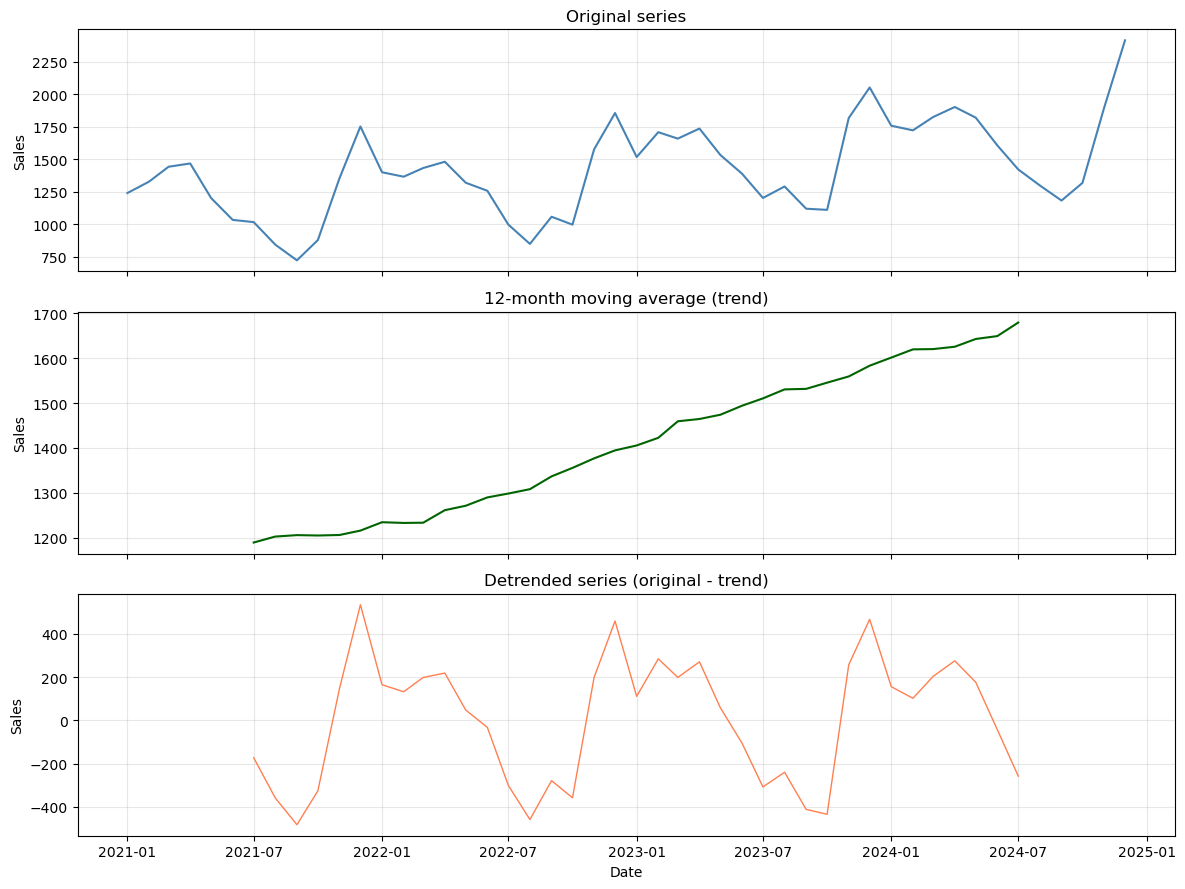

In [129]:
# 3. Create a decomposition plot (conceptual):
#    - Plot with 3 subplots:
#      * Original series
#      * 12-month moving average (trend)
#      * Detrended series (original - trend)
trend_12m = df_sales['Sales'].rolling(window=12, center=True).mean()
detrended = df_sales['Sales'] - trend_12m

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axes[0].plot(df_sales.index, df_sales['Sales'], color='steelblue', linewidth=1.5)
axes[0].set_ylabel('Sales')
axes[0].set_title('Original series')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_sales.index, trend_12m, color='darkgreen', linewidth=1.5)
axes[1].set_ylabel('Sales')
axes[1].set_title('12-month moving average (trend)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_sales.index, detrended, color='coral', linewidth=1)
axes[2].set_ylabel('Sales')
axes[2].set_xlabel('Date')
axes[2].set_title('Detrended series (original - trend)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [130]:
# --------------------------------------------------------------------
# A2: Linear Regression with Trend and Seasonality
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A2: Regression Forecasting")
print("-" * 70)


----------------------------------------------------------------------
A2: Regression Forecasting
----------------------------------------------------------------------


In [131]:
# Create seasonal dummy variables:
#    - 11 dummies for months (leave January as baseline)
#    - Use pd.get_dummies(df_sales['Month'], drop_first=True)
month_dummies = pd.get_dummies(df_sales['Month'], drop_first=True)
# Optional: add to dataframe for use in regression
df_sales = pd.concat([df_sales, month_dummies], axis=1)
print("Seasonal dummies (Feb–Dec, Jan is baseline):")
print(month_dummies.head(14))

Seasonal dummies (Feb–Dec, Jan is baseline):
               2      3      4      5      6      7      8      9      10  \
Date                                                                        
2021-01-01  False  False  False  False  False  False  False  False  False   
2021-02-01   True  False  False  False  False  False  False  False  False   
2021-03-01  False   True  False  False  False  False  False  False  False   
2021-04-01  False  False   True  False  False  False  False  False  False   
2021-05-01  False  False  False   True  False  False  False  False  False   
2021-06-01  False  False  False  False   True  False  False  False  False   
2021-07-01  False  False  False  False  False   True  False  False  False   
2021-08-01  False  False  False  False  False  False   True  False  False   
2021-09-01  False  False  False  False  False  False  False   True  False   
2021-10-01  False  False  False  False  False  False  False  False   True   
2021-11-01  False  False  False

In [132]:
# 2. Fit regression model:
#    Sales = β₀ + β₁(Time) + Σγₘ(Month_m) + ε
# Fit regression: Sales = β₀ + β₁(Time) + Σγₘ(Month_m) + ε
X_reg = df_sales[['Time']].join(month_dummies)
X_reg = sm.add_constant(X_reg)
y = df_sales['Sales'].values
X = X_reg.values.astype(float)
valid = ~(np.isnan(y) | np.isnan(X).any(axis=1))
model_reg = sm.OLS(y[valid], X[valid]).fit()
print(model_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     83.27
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           4.66e-22
Time:                        16:12:21   Log-Likelihood:                -267.91
No. Observations:                  48   AIC:                             561.8
Df Residuals:                      35   BIC:                             586.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1225.9156     40.334     30.394      0.0

In [133]:

# X_reg order: const=0, Time=1, months 2-12 at indices 2..12 (params are position-based when using numpy)
beta1 = model_reg.params[1]
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"\n1. Monthly trend (β₁): {beta1:.4f}")
print(f"   Sales increase by about {beta1:.2f} units per month on average (holding month fixed).")

month_coefs = model_reg.params[2:13]   # indices 2..12 = months Feb..Dec
largest_idx = int(np.argmax(month_coefs))
largest_month = largest_idx + 2        # month number (2-12)
print(f"\n2. Largest seasonal effect: {month_names[largest_month-1]} (month {largest_month})")
print(f"   Coefficient γ_{largest_month} = {month_coefs[largest_idx]:.2f} (vs January baseline).")

param_names = ['const', 'Time'] + month_names[1:]   # Feb..Dec
print("\n3. Significance (α = 0.05):")
print("   Significant coefficients (p < 0.05):")
for i in range(len(model_reg.params)):
    if model_reg.pvalues[i] < 0.05:
        print(f"      {param_names[i]}: coef = {model_reg.params[i]:.4f}, p = {model_reg.pvalues[i]:.4f}")
print("   Not significant (p ≥ 0.05):")
for i in range(len(model_reg.params)):
    if model_reg.pvalues[i] >= 0.05:
        print(f"      {param_names[i]}: coef = {model_reg.params[i]:.4f}, p = {model_reg.pvalues[i]:.4f}")
print("=" * 60)

INTERPRETATION

1. Monthly trend (β₁): 14.0082
   Sales increase by about 14.01 units per month on average (holding month fixed).

2. Largest seasonal effect: Dec (month 12)
   Coefficient γ_12 = 384.97 (vs January baseline).

3. Significance (α = 0.05):
   Significant coefficients (p < 0.05):
      const: coef = 1225.9156, p = 0.0000
      Time: coef = 14.0082, p = 0.0000
      Apr: coef = 125.5783, p = 0.0241
      Jun: coef = -227.1135, p = 0.0001
      Jul: coef = -403.0357, p = 0.0000
      Aug: coef = -506.1995, p = 0.0000
      Sep: coef = -569.8533, p = 0.0000
      Oct: coef = -528.3524, p = 0.0000
      Dec: coef = 384.9678, p = 0.0000
   Not significant (p ≥ 0.05):
      Feb: coef = 38.1279, p = 0.4783
      Mar: coef = 82.5999, p = 0.1296
      May: coef = -66.4715, p = 0.2205
      Nov: coef = 41.3676, p = 0.4471


In [134]:
# 5. Generate fitted values and calculate:
#    - R²
#    - RMSE
#    - MAE
y_fit = model_reg.fittedvalues   # fitted values (same order as y[valid])
y_actual = y[valid]              # actual Sales used in the regression
residuals = y_actual - y_fit

R2 = model_reg.rsquared
RMSE = np.sqrt(np.mean(residuals**2))
MAE = np.mean(np.abs(residuals))

print("=" * 50)
print("FIT STATISTICS")
print("=" * 50)
print(f"  R²   = {R2:.4f}")
print(f"  RMSE = {RMSE:.4f}")
print(f"  MAE  = {MAE:.4f}")
print("=" * 50)

FIT STATISTICS
  R²   = 0.9662
  RMSE = 64.2342
  MAE  = 50.7563


In [135]:
# --------------------------------------------------------------------
# A3: Fourier Terms for Seasonality
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A3: Fourier Seasonality")
print("-" * 70)


----------------------------------------------------------------------
A3: Fourier Seasonality
----------------------------------------------------------------------


In [136]:
# 1. Create Fourier terms for yearly seasonality (m=12):
#    For k=1,2:
#    - sin(2πkt/12)
#    - cos(2πkt/12)
m = 12
t = df_sales['Time'].values
fourier_terms = pd.DataFrame({
    'sin_1': np.sin(2 * np.pi * 1 * t / m),
    'cos_1': np.cos(2 * np.pi * 1 * t / m),
    'sin_2': np.sin(2 * np.pi * 2 * t / m),
    'cos_2': np.cos(2 * np.pi * 2 * t / m),
}, index=df_sales.index)
df_sales = pd.concat([df_sales, fourier_terms], axis=1)
print("Fourier terms (k=1,2) for yearly seasonality, m=12:")
print(fourier_terms.head(14))

Fourier terms (k=1,2) for yearly seasonality, m=12:
                   sin_1         cos_1         sin_2  cos_2
Date                                                       
2021-01-01  0.000000e+00  1.000000e+00  0.000000e+00    1.0
2021-02-01  5.000000e-01  8.660254e-01  8.660254e-01    0.5
2021-03-01  8.660254e-01  5.000000e-01  8.660254e-01   -0.5
2021-04-01  1.000000e+00  6.123234e-17  1.224647e-16   -1.0
2021-05-01  8.660254e-01 -5.000000e-01 -8.660254e-01   -0.5
2021-06-01  5.000000e-01 -8.660254e-01 -8.660254e-01    0.5
2021-07-01  1.224647e-16 -1.000000e+00 -2.449294e-16    1.0
2021-08-01 -5.000000e-01 -8.660254e-01  8.660254e-01    0.5
2021-09-01 -8.660254e-01 -5.000000e-01  8.660254e-01   -0.5
2021-10-01 -1.000000e+00 -1.836970e-16  3.673940e-16   -1.0
2021-11-01 -8.660254e-01  5.000000e-01 -8.660254e-01   -0.5
2021-12-01 -5.000000e-01  8.660254e-01 -8.660254e-01    0.5
2022-01-01 -2.449294e-16  1.000000e+00 -4.898587e-16    1.0
2022-02-01  5.000000e-01  8.660254e-01  8.660254

In [137]:
# 2. Fit regression:
#    Sales = β₀ + β₁(Time) + Σ[αₖsin(2πkt/12) + βₖcos(2πkt/12)] + ε
fourier_cols = ['sin_1', 'cos_1', 'sin_2', 'cos_2']
X_fourier = df_sales[['Time']].join(df_sales[fourier_cols])
X_fourier = sm.add_constant(X_fourier)
y_f = df_sales['Sales'].values
X_f = X_fourier.values.astype(float)
valid_f = ~(np.isnan(y_f) | np.isnan(X_f).any(axis=1))
model_fourier = sm.OLS(y_f[valid_f], X_f[valid_f]).fit()
print(model_fourier.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     52.94
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           4.72e-17
Time:                        16:12:42   Log-Likelihood:                -301.46
No. Observations:                  48   AIC:                             614.9
Df Residuals:                      42   BIC:                             626.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.5202     40.011     26.755      0.0

In [138]:
# 3. Compare with dummy variable model:
#    - R²
#    - AIC
#    - Number of parameters
comparison = pd.DataFrame({
    'Metric': ['R²', 'AIC', 'Number of parameters'],
    'Dummy model': [
        model_reg.rsquared,
        model_reg.aic,
        len(model_reg.params),
    ],
    'Fourier model': [
        model_fourier.rsquared,
        model_fourier.aic,
        len(model_fourier.params),
    ],
})
comparison['Difference'] = comparison['Fourier model'] - comparison['Dummy model']
print("=" * 60)
print("MODEL COMPARISON: Dummy vs Fourier")
print("=" * 60)
print(comparison.to_string(index=False))
print("=" * 60)
print("\nDummy model: 1 const + 1 Time + 11 month dummies = 13 parameters")
print("Fourier model: 1 const + 1 Time + 4 Fourier terms = 6 parameters")

MODEL COMPARISON: Dummy vs Fourier
              Metric  Dummy model  Fourier model  Difference
                  R²     0.966160       0.863054   -0.103106
                 AIC   561.821555     614.923282   53.101727
Number of parameters    13.000000      10.000000   -3.000000

Dummy model: 1 const + 1 Time + 11 month dummies = 13 parameters
Fourier model: 1 const + 1 Time + 4 Fourier terms = 6 parameters


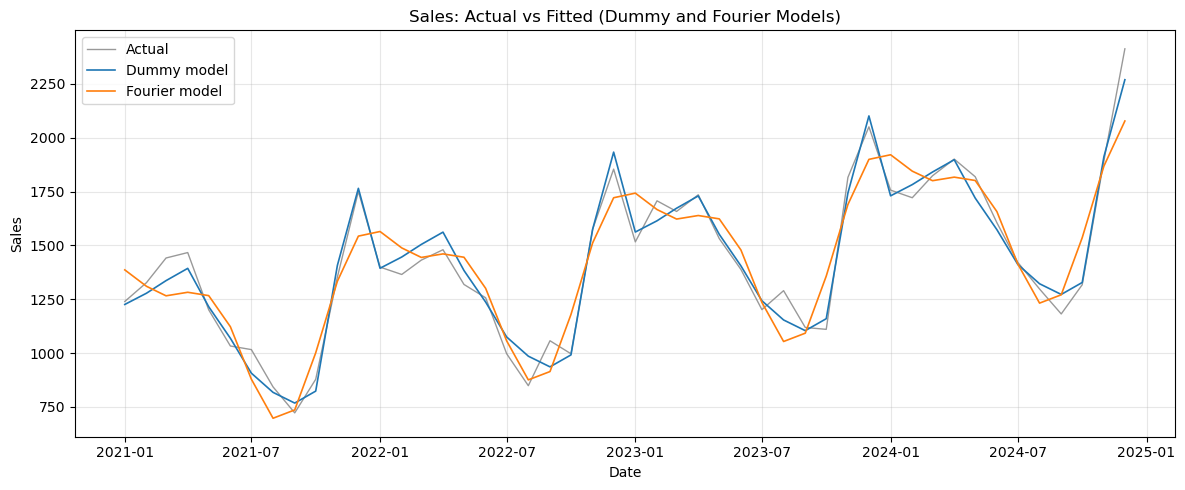

In [139]:
# 4. Plot fitted values from both models on same graph
plt.figure(figsize=(12, 5))
plt.plot(df_sales.index, df_sales['Sales'], label='Actual', color='gray', alpha=0.8, linewidth=1)
plt.plot(df_sales.index[valid], model_reg.fittedvalues, label='Dummy model', linewidth=1.2)
plt.plot(df_sales.index[valid_f], model_fourier.fittedvalues, label='Fourier model', linewidth=1.2)
plt.title('Sales: Actual vs Fitted (Dummy and Fourier Models)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 5. Which approach do you prefer? Why?
#The fourier model can effectively capture 
# seasonal patterns without the messiness of 
# including many dummy variables. 
#The series produced also visually appears 
# smoother than the dummy model which is more jagged.

In [140]:
# --------------------------------------------------------------------
# A4: Simple Exponential Smoothing (SES)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A4: Simple Exponential Smoothing")
print("-" * 70)
# Deseasonalize the data first for SES
# Use only first 36 months for training


----------------------------------------------------------------------
A4: Simple Exponential Smoothing
----------------------------------------------------------------------


In [141]:
# 1. Deseasonalize sales using seasonal averages:
#    - Calculate average sales for each month
#    - Subtract seasonal component
seasonal_avg = df_sales.groupby('Month')['Sales'].transform('mean')  # avg sales by month
df_sales['Sales_deseason'] = df_sales['Sales'] - seasonal_avg
# Use only first 36 months for training
train_months = 36
train_sales = df_sales['Sales_deseason'].iloc[:train_months]
print(f"Deseasonalized sales (first 5):\n{df_sales[['Sales', 'Sales_deseason']].head()}")
print(f"\nTraining set: first {train_months} months, n = {len(train_sales)}")

Deseasonalized sales (first 5):
                  Sales  Sales_deseason
Date                                   
2021-01-01  1239.737132     -238.326014
2021-02-01  1327.143937     -203.055302
2021-03-01  1441.622704     -147.056739
2021-04-01  1466.842389     -178.823643
2021-05-01  1201.075351     -266.549138

Training set: first 36 months, n = 36


In [142]:
# 2. Fit SES on deseasonalized data:
#    - Use SimpleExpSmoothing from statsmodels
#    - Optimize smoothing parameter α
model_ses = SimpleExpSmoothing(train_sales).fit(optimized=True)
alpha_opt = model_ses.params['smoothing_level']
print(f"Fitted SES (deseasonalized, first {train_months} months):")
print(f"  Optimized α = {alpha_opt:.4f}")
print(f"  SSE = {model_ses.sse:.2f}")
print(model_ses.summary())

Fitted SES (deseasonalized, first 36 months):
  Optimized α = 0.3844
  SSE = 272901.21
                       SimpleExpSmoothing Model Results                       
Dep. Variable:         Sales_deseason   No. Observations:                   36
Model:             SimpleExpSmoothing   SSE                         272901.206
Optimized:                       True   AIC                            325.600
Trend:                           None   BIC                            328.768
Seasonal:                        None   AICC                           326.891
Seasonal Periods:                None   Date:                 Tue, 10 Feb 2026
Box-Cox:                        False   Time:                         16:12:59
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3844439        

In [143]:
# 3. Print:
#    - Optimized α value
#    - What does this value tell you about the series?
print("=" * 60)
print("SES SMOOTHING PARAMETER")
print("=" * 60)
print(f"Optimized α = {alpha_opt:.4f}\n")
print("Interpretation:")
if alpha_opt < 0.3:
    print("  α is low → the model puts more weight on the history of the series.")
    print("  Level updates slowly; the series is relatively stable (low volatility).")
elif alpha_opt > 0.7:
    print("  α is high → the model puts more weight on the most recent observation.")
    print("  Level updates quickly; the series reacts strongly to new values.")
else:
    print("  α is in the middle → a balance between history and the latest observation.")
    print("  The series has moderate persistence and some responsiveness to new data.")
print("=" * 60)

SES SMOOTHING PARAMETER
Optimized α = 0.3844

Interpretation:
  α is in the middle → a balance between history and the latest observation.
  The series has moderate persistence and some responsiveness to new data.


In [144]:
# 4. Generate forecasts for next 12 months
forecast_steps = 12
ses_forecast = model_ses.forecast(forecast_steps)
# Forecast dates: first month after training end
train_end_idx = train_months - 1
forecast_dates = df_sales.index[train_end_idx + 1: train_end_idx + 1 + forecast_steps]
forecast_series = pd.Series(ses_forecast, index=forecast_dates)
print("SES forecasts (deseasonalized) for next 12 months:")
print(forecast_series.to_string())
print(f"\nForecast mean (deseasonalized): {forecast_series.mean():.2f}")

SES forecasts (deseasonalized) for next 12 months:
Date
2024-01-01    80.923645
2024-02-01    80.923645
2024-03-01    80.923645
2024-04-01    80.923645
2024-05-01    80.923645
2024-06-01    80.923645
2024-07-01    80.923645
2024-08-01    80.923645
2024-09-01    80.923645
2024-10-01    80.923645
2024-11-01    80.923645
2024-12-01    80.923645

Forecast mean (deseasonalized): 80.92


In [145]:
# 5. Add seasonality back to forecasts
monthly_means = df_sales.groupby('Month')['Sales'].mean()
# For each forecast date, add the seasonal avg for that month
seasonal_component = monthly_means.reindex(forecast_dates.month).values
sales_forecast = forecast_series.values + seasonal_component
sales_forecast_series = pd.Series(sales_forecast, index=forecast_dates)
print("SES forecasts with seasonality added back (next 12 months):")
print(sales_forecast_series.to_string())
print(f"\nForecast mean (with seasonality): {sales_forecast_series.mean():.2f}")

SES forecasts with seasonality added back (next 12 months):
Date
2024-01-01    1558.986791
2024-02-01    1611.122884
2024-03-01    1669.603088
2024-04-01    1726.589677
2024-05-01    1548.548134
2024-06-01    1401.914262
2024-07-01    1240.000322
2024-08-01    1150.844675
2024-09-01    1101.199127
2024-10-01    1156.708217
2024-11-01    1740.436357
2024-12-01    2098.044739

Forecast mean (with seasonality): 1500.33


In [146]:
# 6. Calculate forecast accuracy on holdout period
actual_holdout = df_sales['Sales'].loc[forecast_dates]
errors = actual_holdout - sales_forecast_series
RMSE_holdout = np.sqrt(np.mean(errors**2))
MAE_holdout = np.mean(np.abs(errors))
MAPE_holdout = np.mean(np.abs(errors / actual_holdout)) * 100

print("=" * 55)
print("FORECAST ACCURACY (holdout: months 37–48)")
print("=" * 55)
print(f"  RMSE = {RMSE_holdout:.2f}")
print(f"  MAE  = {MAE_holdout:.2f}")
print(f"  MAPE = {MAPE_holdout:.2f}%")
print("=" * 55)
print("\nActual vs forecast (holdout):")
print(pd.DataFrame({'Actual': actual_holdout, 'Forecast': sales_forecast_series, 'Error': errors}).to_string())

FORECAST ACCURACY (holdout: months 37–48)
  RMSE = 189.04
  MAE  = 178.89
  MAPE = 10.58%

Actual vs forecast (holdout):
                 Actual     Forecast       Error
Date                                            
2024-01-01  1756.709088  1558.986791  197.722297
2024-02-01  1721.431471  1611.122884  110.308587
2024-03-01  1823.552737  1669.603088  153.949649
2024-04-01  1900.748899  1726.589677  174.159222
2024-05-01  1818.884948  1548.548134  270.336813
2024-06-01  1605.504382  1401.914262  203.590119
2024-07-01  1420.748137  1240.000322  180.747815
2024-08-01  1297.706624  1150.844675  146.861949
2024-09-01  1181.910620  1101.199127   80.711492
2024-10-01  1317.412463  1156.708217  160.704246
2024-11-01  1893.341277  1740.436357  152.904920
2024-12-01  2412.774859  2098.044739  314.730120


In [147]:
# 1. Fit Holt's linear trend method:
#    - Use ExponentialSmoothing with trend='add', seasonal=None
#    - On deseasonalized data
model_holt = ExponentialSmoothing(
    train_sales,
    trend='add',
    seasonal=None,
).fit(optimized=True)
print("Holt's linear trend (deseasonalized, first 36 months):")
print(f"  α (level) = {model_holt.params['smoothing_level']:.4f}")
print(f"  β (trend) = {model_holt.params['smoothing_trend']:.4f}")
print(f"  SSE = {model_holt.sse:.2f}")
print(model_holt.summary())

Holt's linear trend (deseasonalized, first 36 months):
  α (level) = 0.0020
  β (trend) = 0.0000
  SSE = 229734.68
                       ExponentialSmoothing Model Results                       
Dep. Variable:           Sales_deseason   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                         229734.679
Optimized:                         True   AIC                            323.402
Trend:                         Additive   BIC                            329.736
Seasonal:                          None   AICC                           326.298
Seasonal Periods:                  None   Date:                 Tue, 10 Feb 2026
Box-Cox:                          False   Time:                         16:13:18
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
-----------------------------------------------------------------------------

In [148]:
# 2. Print optimized parameters:
#    - α (level smoothing)
#    - β (trend smoothing)
alpha_holt = model_holt.params['smoothing_level']
beta_holt = model_holt.params['smoothing_trend']
print("=" * 50)
print("HOLT OPTIMIZED PARAMETERS")
print("=" * 50)
print(f"  α (level smoothing) = {alpha_holt:.4f}")
print(f"  β (trend smoothing) = {beta_holt:.4f}")
print("=" * 50)

HOLT OPTIMIZED PARAMETERS
  α (level smoothing) = 0.0020
  β (trend smoothing) = 0.0000


In [149]:
# 3. Extract final state:
#    - Level (ℓₜ)
#    - Trend (bₜ)
level_final = model_holt.level[-1]   # ℓ_T at end of training
trend_final = model_holt.trend[-1]   # b_T (trend) at end of training
print("=" * 50)
print("HOLT FINAL STATE (end of training)")
print("=" * 50)
print(f"  Level ℓₜ = {level_final:.4f}")
print(f"  Trend bₜ = {trend_final:.4f}")
print("=" * 50)

HOLT FINAL STATE (end of training)
  Level ℓₜ = 120.5671
  Trend bₜ = 11.8622


In [150]:
# 4. Generate 12-month forecasts
holt_forecast = model_holt.forecast(forecast_steps)
holt_forecast_series = pd.Series(holt_forecast, index=forecast_dates)
print("Holt 12-month forecasts (deseasonalized):")
print(holt_forecast_series.to_string())
print(f"\nForecast mean (deseasonalized): {holt_forecast_series.mean():.2f}")

Holt 12-month forecasts (deseasonalized):
Date
2024-01-01    132.429303
2024-02-01    144.291542
2024-03-01    156.153782
2024-04-01    168.016021
2024-05-01    179.878261
2024-06-01    191.740500
2024-07-01    203.602740
2024-08-01    215.464979
2024-09-01    227.327219
2024-10-01    239.189458
2024-11-01    251.051697
2024-12-01    262.913937

Forecast mean (deseasonalized): 197.67


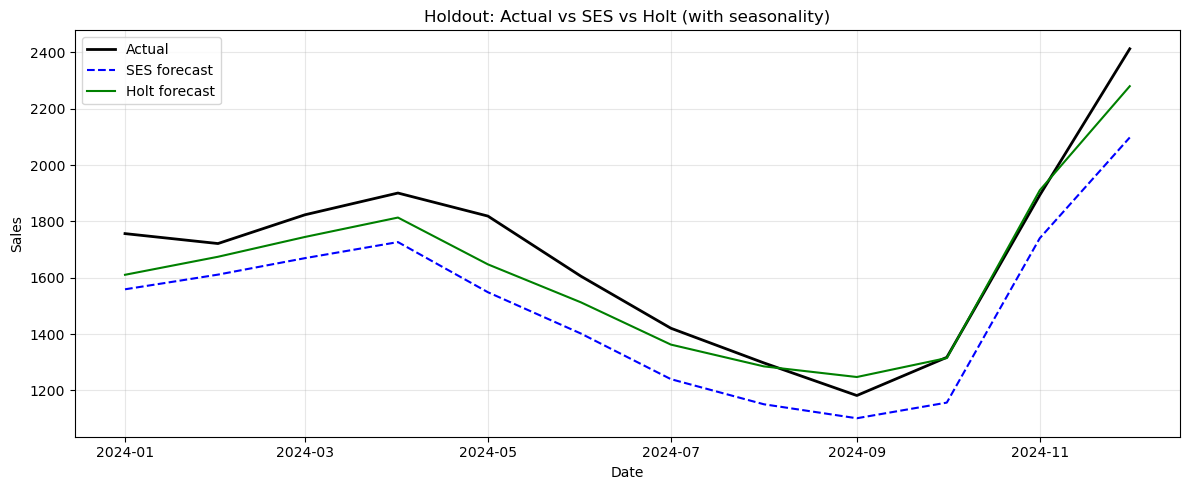

Which captures the trend better?
  Holt captures the trend better: it includes an explicit trend term (bₜ), so
  forecasts can slope up or down. SES has a constant level, so its forecast
  path is flat (after adding seasonality, only seasonal variation).


In [151]:
# 5. Compare with SES:
#    - Plot both forecast paths
#    - Which captures the trend better?
# Add seasonality back to Holt forecasts (same scale as SES)
holt_seasonal = monthly_means.reindex(forecast_dates.month).values
holt_sales_forecast = pd.Series(holt_forecast_series.values + holt_seasonal, index=forecast_dates)

plt.figure(figsize=(12, 5))
plt.plot(forecast_dates, actual_holdout, 'k-', label='Actual', linewidth=2)
plt.plot(forecast_dates, sales_forecast_series, 'b--', label='SES forecast', linewidth=1.5)
plt.plot(forecast_dates, holt_sales_forecast, 'g-', label='Holt forecast', linewidth=1.5)
plt.title('Holdout: Actual vs SES vs Holt (with seasonality)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Which captures the trend better?")
print("  Holt captures the trend better: it includes an explicit trend term (bₜ), so")
print("  forecasts can slope up or down. SES has a constant level, so its forecast")
print("  path is flat (after adding seasonality, only seasonal variation).")

In [152]:
# 1. Fit Holt-Winters with additive seasonality:
#    - Use ExponentialSmoothing
#    - trend='add', seasonal='add', seasonal_periods=12
#    - Use first 36 months for training
train_months = 36
train_sales_hw = df_sales['Sales'].iloc[:train_months]
model_hw = ExponentialSmoothing(
    train_sales_hw,
    trend='add',
    seasonal='add',
    seasonal_periods=12,
).fit(optimized=True)
print("Holt-Winters (additive trend + additive seasonal, first 36 months):")
print(f"  α (level) = {model_hw.params['smoothing_level']:.4f}")
print(f"  β (trend) = {model_hw.params['smoothing_trend']:.4f}")
print(f"  γ (seasonal) = {model_hw.params['smoothing_seasonal']:.4f}")
print(f"  SSE = {model_hw.sse:.2f}")
print(model_hw.summary())

Holt-Winters (additive trend + additive seasonal, first 36 months):
  α (level) = 0.2117
  β (trend) = 0.1817
  γ (seasonal) = 0.0057
  SSE = 151628.18
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                         151628.183
Optimized:                         True   AIC                            332.444
Trend:                         Additive   BIC                            357.780
Seasonal:                      Additive   AICC                           372.679
Seasonal Periods:                    12   Date:                 Tue, 10 Feb 2026
Box-Cox:                          False   Time:                         16:13:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
-------------------------------------

In [153]:
# 2. Print optimized parameters:
#    - α, β, γ (seasonal smoothing)
alpha_hw = model_hw.params['smoothing_level']
beta_hw = model_hw.params['smoothing_trend']
gamma_hw = model_hw.params['smoothing_seasonal']
print("=" * 55)
print("HOLT-WINTERS OPTIMIZED PARAMETERS")
print("=" * 55)
print(f"  α (level smoothing)    = {alpha_hw:.4f}")
print(f"  β (trend smoothing)   = {beta_hw:.4f}")
print(f"  γ (seasonal smoothing) = {gamma_hw:.4f}")
print("=" * 55)

HOLT-WINTERS OPTIMIZED PARAMETERS
  α (level smoothing)    = 0.2117
  β (trend smoothing)   = 0.1817
  γ (seasonal smoothing) = 0.0057


In [154]:
# 3. Extract components:
#    - Level
#    - Trend
#    - Seasonal indices
level_hw = model_hw.level[-1]
trend_hw = model_hw.trend[-1]
seasonal_indices = model_hw.season[-12:]   # last 12 = one per month (Jan-Dec)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

print("=" * 55)
print("HOLT-WINTERS COMPONENTS (end of training)")
print("=" * 55)
print(f"  Level (ℓₜ) = {level_hw:.4f}")
print(f"  Trend (bₜ) = {trend_hw:.4f}")
print("\n  Seasonal indices (additive, by month):")
for m, s in zip(month_names, seasonal_indices):
    print(f"    {m}: {s:.4f}")
print("=" * 55)

HOLT-WINTERS COMPONENTS (end of training)
  Level (ℓₜ) = 1600.7844
  Trend (bₜ) = 16.0867

  Seasonal indices (additive, by month):
    Jan: 116.0296
    Feb: 186.2327
    Mar: 218.8611
    Apr: 257.4003
    May: 35.2106
    Jun: -101.5192
    Jul: -268.2896
    Aug: -358.7254
    Sep: -399.5565
    Oct: -384.0654
    Nov: 188.8431
    Dec: 478.6325


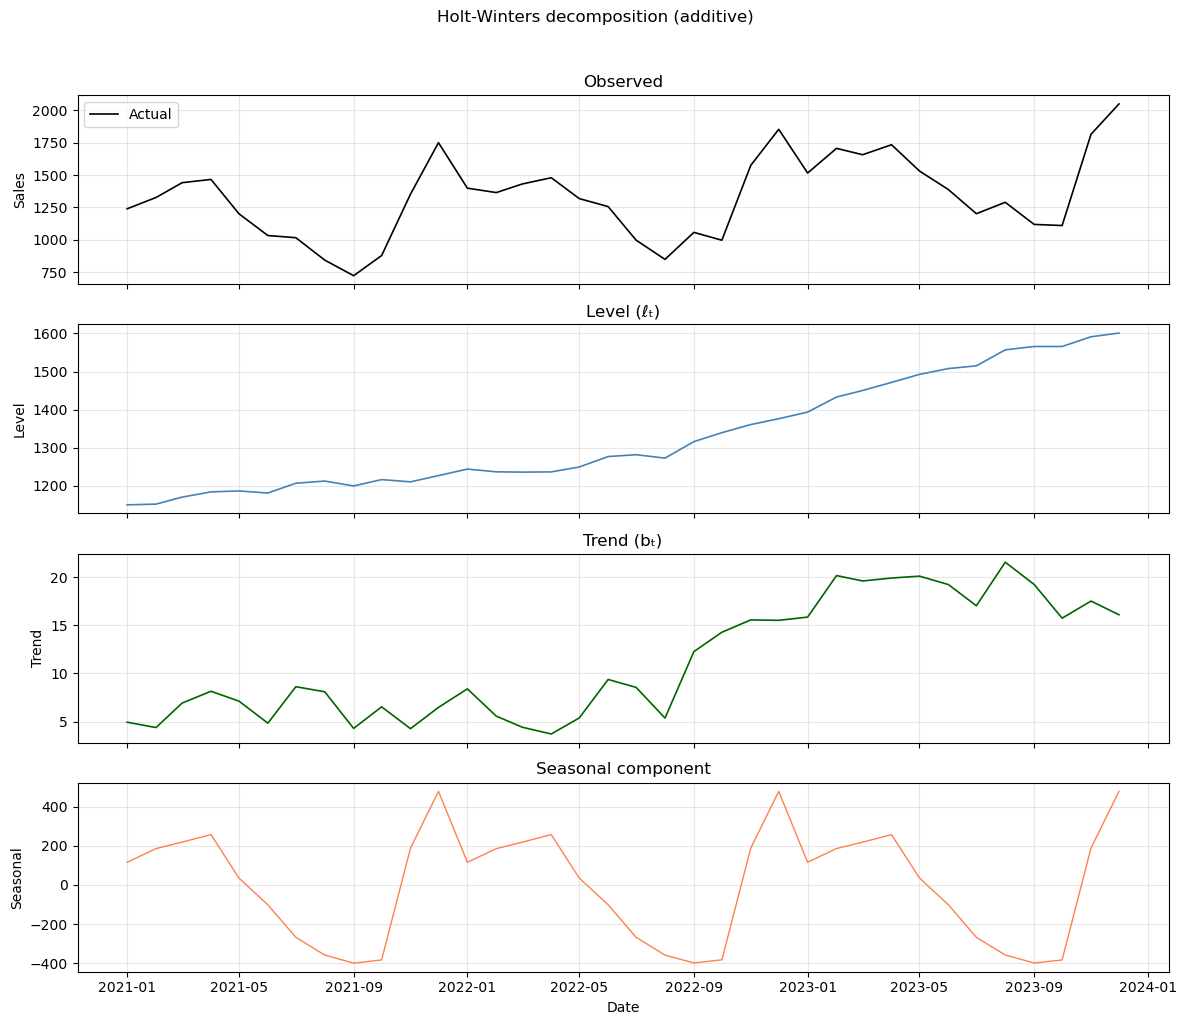

In [155]:
# 4. Plot decomposition from Holt-Winters
train_idx = train_sales_hw.index
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(train_idx, train_sales_hw, 'k-', linewidth=1.2, label='Actual')
axes[0].set_ylabel('Sales')
axes[0].set_title('Observed')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_idx, model_hw.level, color='steelblue', linewidth=1.2)
axes[1].set_ylabel('Level')
axes[1].set_title('Level (ℓₜ)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(train_idx, model_hw.trend, color='darkgreen', linewidth=1.2)
axes[2].set_ylabel('Trend')
axes[2].set_title('Trend (bₜ)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(train_idx, model_hw.season, color='coral', linewidth=1)
axes[3].set_ylabel('Seasonal')
axes[3].set_xlabel('Date')
axes[3].set_title('Seasonal component')
axes[3].grid(True, alpha=0.3)

plt.suptitle("Holt-Winters decomposition (additive)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [156]:
# 5. Generate 12-month forecasts
hw_forecast_steps = 12
hw_forecast = model_hw.forecast(hw_forecast_steps)
hw_forecast_dates = df_sales.index[train_months: train_months + hw_forecast_steps]
hw_forecast_series = pd.Series(hw_forecast, index=hw_forecast_dates)
print("Holt-Winters 12-month forecasts:")
print(hw_forecast_series.to_string())
print(f"\nForecast mean: {hw_forecast_series.mean():.2f}")

Holt-Winters 12-month forecasts:
Date
2024-01-01    1732.900724
2024-02-01    1819.190449
2024-03-01    1867.905568
2024-04-01    1922.531429
2024-05-01    1716.428431
2024-06-01    1595.785304
2024-07-01    1445.101674
2024-08-01    1370.752493
2024-09-01    1346.008094
2024-10-01    1377.585897
2024-11-01    1966.581065
2024-12-01    2272.666224

Forecast mean: 1702.79


In [157]:
# 6. Compare forecast accuracy with:
#    - Regression model
#    - SES
#    - Holt's method
#    - Holt-Winters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

holdout_idx = df_sales.index[36:48]
y_act = df_sales['Sales'].loc[holdout_idx].values
train_months = 36
forecast_steps = 12

# --- Regression: use model_reg if available, else fit on first 36 months ---
try:
    try:
        md = month_dummies
    except NameError:
        md = pd.get_dummies(df_sales['Month'], drop_first=True)
    X_holdout = df_sales[['Time']].join(md).iloc[36:48]
    X_holdout = sm.add_constant(X_holdout).values.astype(float)
    try:
        reg_forecast = X_holdout @ model_reg.params
    except NameError:
        X_train = df_sales[['Time']].join(md).iloc[:36]
        X_train = sm.add_constant(X_train).values.astype(float)
        y_train = df_sales['Sales'].iloc[:36].values
        fit = sm.OLS(y_train, X_train).fit()
        reg_forecast = X_holdout @ fit.params
    reg_rmse = np.sqrt(np.mean((y_act - reg_forecast)**2))
    reg_mae = np.mean(np.abs(y_act - reg_forecast))
except Exception as e:
    reg_rmse = reg_mae = np.nan
    print("Regression:", e)

# --- SES: use sales_forecast_series if available, else fit and forecast ---
try:
    try:
        ses_f = sales_forecast_series.values if len(sales_forecast_series) == 12 else None
    except (NameError, TypeError):
        ses_f = None
    if ses_f is None:
        seasonal_avg = df_sales.groupby('Month')['Sales'].transform('mean')
        train_sales = (df_sales['Sales'] - seasonal_avg).iloc[:train_months]
        mod_ses = SimpleExpSmoothing(train_sales).fit(optimized=True)
        ses_deseason = mod_ses.forecast(forecast_steps)
        fd = df_sales.index[36:36+forecast_steps]
        mm = df_sales.groupby('Month')['Sales'].mean()
        ses_f = ses_deseason + mm.reindex(fd.month).values
    ses_rmse = np.sqrt(np.mean((y_act - ses_f)**2))
    ses_mae = np.mean(np.abs(y_act - ses_f))
except Exception as e:
    ses_rmse = ses_mae = np.nan
    print("SES:", e)

# --- Holt: use holt_sales_forecast if available, else fit and forecast ---
try:
    try:
        holt_f = holt_sales_forecast.values if len(holt_sales_forecast) == 12 else None
    except (NameError, TypeError):
        holt_f = None
    if holt_f is None:
        seasonal_avg = df_sales.groupby('Month')['Sales'].transform('mean')
        train_sales = (df_sales['Sales'] - seasonal_avg).iloc[:train_months]
        mod_holt = ExponentialSmoothing(train_sales, trend='add', seasonal=None).fit(optimized=True)
        holt_deseason = mod_holt.forecast(forecast_steps)
        fd = df_sales.index[36:36+forecast_steps]
        mm = df_sales.groupby('Month')['Sales'].mean()
        holt_f = holt_deseason + mm.reindex(fd.month).values
    holt_rmse = np.sqrt(np.mean((y_act - holt_f)**2))
    holt_mae = np.mean(np.abs(y_act - holt_f))
except Exception as e:
    holt_rmse = holt_mae = np.nan
    print("Holt:", e)

# --- Holt-Winters ---
try:
    hw_rmse = np.sqrt(np.mean((y_act - hw_forecast_series.values)**2))
    hw_mae = np.mean(np.abs(y_act - hw_forecast_series.values))
except Exception:
    hw_rmse = hw_mae = np.nan

acc = pd.DataFrame({
    'Model': ['Regression (dummy)', 'SES', "Holt's", 'Holt-Winters'],
    'RMSE': [reg_rmse, ses_rmse, holt_rmse, hw_rmse],
    'MAE': [reg_mae, ses_mae, holt_mae, hw_mae],
})
print("=" * 60)
print("FORECAST ACCURACY COMPARISON (holdout: months 37–48)")
print("=" * 60)
print(acc.to_string(index=False))
print("=" * 60)
print("\nLower RMSE/MAE = better accuracy.")
if acc['RMSE'].isna().any():
    missing = acc.loc[acc['RMSE'].isna(), 'Model'].tolist()
    print(f"\nMissing (run sections above): {missing}")

FORECAST ACCURACY COMPARISON (holdout: months 37–48)
             Model       RMSE        MAE
Regression (dummy)  61.581776  44.653795
               SES 189.041071 178.893936
            Holt's  91.788042  75.965163
      Holt-Winters  83.978777  69.574753

Lower RMSE/MAE = better accuracy.


In [158]:
# 3. Print:
#    - Optimized α value
#    - What does this value tell you about the series?
print("=" * 60)
print("SES SMOOTHING PARAMETER")
print("=" * 60)
print(f"Optimized α = {alpha_opt:.4f}\n")
print("Interpretation:")
if alpha_opt < 0.3:
    print("  α is low → the model puts more weight on the history of the series.")
    print("  Level updates slowly; the series is relatively stable (low volatility).")
elif alpha_opt > 0.7:
    print("  α is high → the model puts more weight on the most recent observation.")
    print("  Level updates quickly; the series reacts strongly to new values.")
else:
    print("  α is in the middle → a balance between history and the latest observation.")
    print("  The series has moderate persistence and some responsiveness to new data.")
print("=" * 60)

SES SMOOTHING PARAMETER
Optimized α = 0.3844

Interpretation:
  α is in the middle → a balance between history and the latest observation.
  The series has moderate persistence and some responsiveness to new data.


In [159]:
# 4. Generate forecasts for next 12 months
forecast_steps = 12
ses_forecast = model_ses.forecast(forecast_steps)
# Forecast dates: first month after training end
train_end_idx = train_months - 1
forecast_dates = df_sales.index[train_end_idx + 1: train_end_idx + 1 + forecast_steps]
forecast_series = pd.Series(ses_forecast, index=forecast_dates)
print("SES forecasts (deseasonalized) for next 12 months:")
print(forecast_series.to_string())
print(f"\nForecast mean (deseasonalized): {forecast_series.mean():.2f}")

SES forecasts (deseasonalized) for next 12 months:
Date
2024-01-01    80.923645
2024-02-01    80.923645
2024-03-01    80.923645
2024-04-01    80.923645
2024-05-01    80.923645
2024-06-01    80.923645
2024-07-01    80.923645
2024-08-01    80.923645
2024-09-01    80.923645
2024-10-01    80.923645
2024-11-01    80.923645
2024-12-01    80.923645

Forecast mean (deseasonalized): 80.92


In [160]:
# 5. Add seasonality back to forecasts
monthly_means = df_sales.groupby('Month')['Sales'].mean()
# For each forecast date, add the seasonal avg for that month
seasonal_component = monthly_means.reindex(forecast_dates.month).values
sales_forecast = forecast_series.values + seasonal_component
sales_forecast_series = pd.Series(sales_forecast, index=forecast_dates)
print("SES forecasts with seasonality added back (next 12 months):")
print(sales_forecast_series.to_string())
print(f"\nForecast mean (with seasonality): {sales_forecast_series.mean():.2f}")

SES forecasts with seasonality added back (next 12 months):
Date
2024-01-01    1558.986791
2024-02-01    1611.122884
2024-03-01    1669.603088
2024-04-01    1726.589677
2024-05-01    1548.548134
2024-06-01    1401.914262
2024-07-01    1240.000322
2024-08-01    1150.844675
2024-09-01    1101.199127
2024-10-01    1156.708217
2024-11-01    1740.436357
2024-12-01    2098.044739

Forecast mean (with seasonality): 1500.33


In [161]:
# 6. Calculate forecast accuracy on holdout period
actual_holdout = df_sales['Sales'].loc[forecast_dates]
errors = actual_holdout - sales_forecast_series
RMSE_holdout = np.sqrt(np.mean(errors**2))
MAE_holdout = np.mean(np.abs(errors))
MAPE_holdout = np.mean(np.abs(errors / actual_holdout)) * 100

print("=" * 55)
print("FORECAST ACCURACY (holdout: months 37–48)")
print("=" * 55)
print(f"  RMSE = {RMSE_holdout:.2f}")
print(f"  MAE  = {MAE_holdout:.2f}")
print(f"  MAPE = {MAPE_holdout:.2f}%")
print("=" * 55)
print("\nActual vs forecast (holdout):")
print(pd.DataFrame({'Actual': actual_holdout, 'Forecast': sales_forecast_series, 'Error': errors}).to_string())

FORECAST ACCURACY (holdout: months 37–48)
  RMSE = 189.04
  MAE  = 178.89
  MAPE = 10.58%

Actual vs forecast (holdout):
                 Actual     Forecast       Error
Date                                            
2024-01-01  1756.709088  1558.986791  197.722297
2024-02-01  1721.431471  1611.122884  110.308587
2024-03-01  1823.552737  1669.603088  153.949649
2024-04-01  1900.748899  1726.589677  174.159222
2024-05-01  1818.884948  1548.548134  270.336813
2024-06-01  1605.504382  1401.914262  203.590119
2024-07-01  1420.748137  1240.000322  180.747815
2024-08-01  1297.706624  1150.844675  146.861949
2024-09-01  1181.910620  1101.199127   80.711492
2024-10-01  1317.412463  1156.708217  160.704246
2024-11-01  1893.341277  1740.436357  152.904920
2024-12-01  2412.774859  2098.044739  314.730120


In [162]:
# A5: Holt's Linear Trend Method
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A5: Holt's Method")
print("-" * 70)


----------------------------------------------------------------------
A5: Holt's Method
----------------------------------------------------------------------


In [163]:
# 1. Fit Holt's linear trend method:
#    - Use ExponentialSmoothing with trend='add', seasonal=None
#    - On deseasonalized data
model_holt = ExponentialSmoothing(
    train_sales,
    trend='add',
    seasonal=None,
).fit(optimized=True)
print("Holt's linear trend (deseasonalized, first 36 months):")
print(f"  α (level) = {model_holt.params['smoothing_level']:.4f}")
print(f"  β (trend) = {model_holt.params['smoothing_trend']:.4f}")
print(f"  SSE = {model_holt.sse:.2f}")
print(model_holt.summary())

Holt's linear trend (deseasonalized, first 36 months):
  α (level) = 0.0020
  β (trend) = 0.0000
  SSE = 229734.68
                       ExponentialSmoothing Model Results                       
Dep. Variable:           Sales_deseason   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                         229734.679
Optimized:                         True   AIC                            323.402
Trend:                         Additive   BIC                            329.736
Seasonal:                          None   AICC                           326.298
Seasonal Periods:                  None   Date:                 Tue, 10 Feb 2026
Box-Cox:                          False   Time:                         16:14:25
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
-----------------------------------------------------------------------------

In [164]:
# 2. Print optimized parameters:
#    - α (level smoothing)
#    - β (trend smoothing)
alpha_holt = model_holt.params['smoothing_level']
beta_holt = model_holt.params['smoothing_trend']
print("=" * 50)
print("HOLT OPTIMIZED PARAMETERS")
print("=" * 50)
print(f"  α (level smoothing) = {alpha_holt:.4f}")
print(f"  β (trend smoothing) = {beta_holt:.4f}")
print("=" * 50)

HOLT OPTIMIZED PARAMETERS
  α (level smoothing) = 0.0020
  β (trend smoothing) = 0.0000


In [165]:
# 3. Extract final state:
#    - Level (ℓₜ)
#    - Trend (bₜ)
trend_final = model_holt.trend[-1]   # b_T (trend) at end of training
level_final = model_holt.level[-1]   # ℓ_T at end of training
  # b_T (trend) at end of training
print("=" * 50)
print("HOLT FINAL STATE (end of training)")
print("=" * 50)
print(f"  Level ℓₜ = {level_final:.4f}")
print(f"  Trend bₜ = {trend_final:.4f}")
print("=" * 50)

HOLT FINAL STATE (end of training)
  Level ℓₜ = 120.5671
  Trend bₜ = 11.8622


In [166]:
# 4. Generate 12-month forecasts
holt_forecast = model_holt.forecast(forecast_steps)
holt_forecast_series = pd.Series(holt_forecast, index=forecast_dates)
print("Holt 12-month forecasts (deseasonalized):")
print(holt_forecast_series.to_string())
print(f"\nForecast mean (deseasonalized): {holt_forecast_series.mean():.2f}")

Holt 12-month forecasts (deseasonalized):
Date
2024-01-01    132.429303
2024-02-01    144.291542
2024-03-01    156.153782
2024-04-01    168.016021
2024-05-01    179.878261
2024-06-01    191.740500
2024-07-01    203.602740
2024-08-01    215.464979
2024-09-01    227.327219
2024-10-01    239.189458
2024-11-01    251.051697
2024-12-01    262.913937

Forecast mean (deseasonalized): 197.67


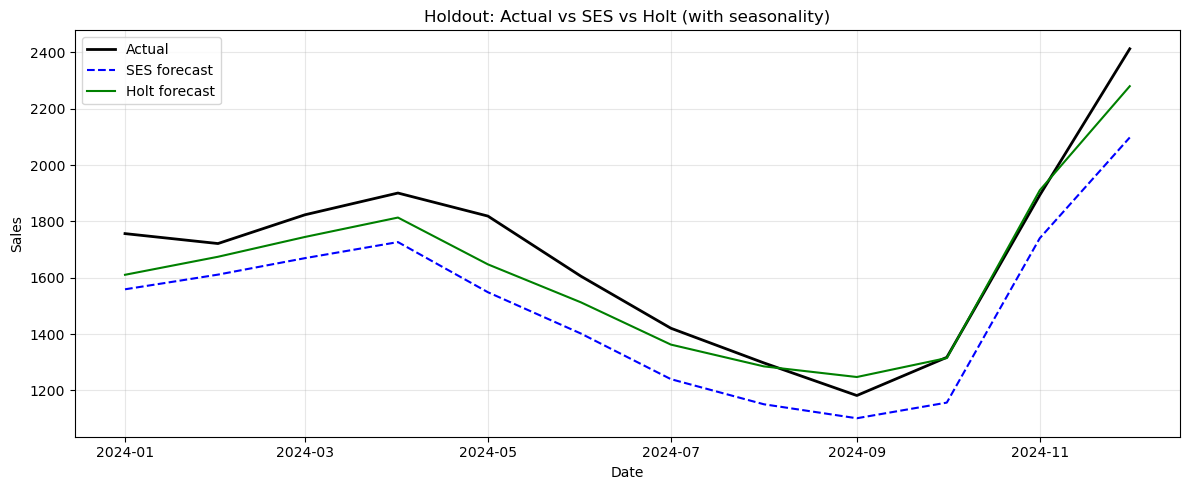

Which captures the trend better?
  Holt captures the trend better: it includes an explicit trend term (bₜ), so
  forecasts can slope up or down. SES has a constant level, so its forecast
  path is flat (after adding seasonality, only seasonal variation).


In [167]:
# 5. Compare with SES:
#    - Plot both forecast paths
#    - Which captures the trend better?
# Add seasonality back to Holt forecasts (same scale as SES)
holt_seasonal = monthly_means.reindex(forecast_dates.month).values
holt_sales_forecast = pd.Series(holt_forecast_series.values + holt_seasonal, index=forecast_dates)

plt.figure(figsize=(12, 5))
plt.plot(forecast_dates, actual_holdout, 'k-', label='Actual', linewidth=2)
plt.plot(forecast_dates, sales_forecast_series, 'b--', label='SES forecast', linewidth=1.5)
plt.plot(forecast_dates, holt_sales_forecast, 'g-', label='Holt forecast', linewidth=1.5)
plt.title('Holdout: Actual vs SES vs Holt (with seasonality)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Which captures the trend better?")
print("  Holt captures the trend better: it includes an explicit trend term (bₜ), so")
print("  forecasts can slope up or down. SES has a constant level, so its forecast")
print("  path is flat (after adding seasonality, only seasonal variation).")

In [168]:
# --------------------------------------------------------------------
# A6: Holt-Winters Seasonal Method
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A6: Holt-Winters Method")
print("-" * 70)


----------------------------------------------------------------------
A6: Holt-Winters Method
----------------------------------------------------------------------


In [169]:
  #    - Use first 36 months for training\n,
        
train_months = 36
train_sales_hw = df_sales['Sales'].iloc[:train_months]

In [170]:
# 1. Fit Holt-Winters with additive seasonality:
#    - Use ExponentialSmoothing
#    - trend='add', seasonal='add', seasonal_periods=12
#    - Use first 36 months for training
train_months = 36
train_sales_hw = df_sales['Sales'].iloc[:train_months]
model_hw = ExponentialSmoothing(
    train_sales_hw,
    trend='add',
    seasonal='add',
    seasonal_periods=12,
).fit(optimized=True)
print("Holt-Winters (additive trend + additive seasonal, first 36 months):")
print(f"  α (level) = {model_hw.params['smoothing_level']:.4f}")
print(f"  β (trend) = {model_hw.params['smoothing_trend']:.4f}")
print(f"  γ (seasonal) = {model_hw.params['smoothing_seasonal']:.4f}")
print(f"  SSE = {model_hw.sse:.2f}")
print(model_hw.summary())

Holt-Winters (additive trend + additive seasonal, first 36 months):
  α (level) = 0.2117
  β (trend) = 0.1817
  γ (seasonal) = 0.0057
  SSE = 151628.18
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                         151628.183
Optimized:                         True   AIC                            332.444
Trend:                         Additive   BIC                            357.780
Seasonal:                      Additive   AICC                           372.679
Seasonal Periods:                    12   Date:                 Tue, 10 Feb 2026
Box-Cox:                          False   Time:                         16:14:51
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
-------------------------------------

In [171]:
# 2. Print optimized parameters:
#    - α, β, γ (seasonal smoothing)
alpha_hw = model_hw.params['smoothing_level']
beta_hw = model_hw.params['smoothing_trend']
gamma_hw = model_hw.params['smoothing_seasonal']
print("=" * 55)
print("HOLT-WINTERS OPTIMIZED PARAMETERS")
print("=" * 55)
print(f"  α (level smoothing)    = {alpha_hw:.4f}")
print(f"  β (trend smoothing)   = {beta_hw:.4f}")
print(f"  γ (seasonal smoothing) = {gamma_hw:.4f}")
print("=" * 55)

HOLT-WINTERS OPTIMIZED PARAMETERS
  α (level smoothing)    = 0.2117
  β (trend smoothing)   = 0.1817
  γ (seasonal smoothing) = 0.0057


In [172]:
# 3. Extract components:
#    - Level
#    - Trend
#    - Seasonal indices
level_hw = model_hw.level[-1]
trend_hw = model_hw.trend[-1]
seasonal_indices = model_hw.season[-12:]   # last 12 = one per month (Jan-Dec)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

print("=" * 55)
print("HOLT-WINTERS COMPONENTS (end of training)")
print("=" * 55)
print(f"  Level (ℓₜ) = {level_hw:.4f}")
print(f"  Trend (bₜ) = {trend_hw:.4f}")
print("\n  Seasonal indices (additive, by month):")
for m, s in zip(month_names, seasonal_indices):
    print(f"    {m}: {s:.4f}")
print("=" * 55)

HOLT-WINTERS COMPONENTS (end of training)
  Level (ℓₜ) = 1600.7844
  Trend (bₜ) = 16.0867

  Seasonal indices (additive, by month):
    Jan: 116.0296
    Feb: 186.2327
    Mar: 218.8611
    Apr: 257.4003
    May: 35.2106
    Jun: -101.5192
    Jul: -268.2896
    Aug: -358.7254
    Sep: -399.5565
    Oct: -384.0654
    Nov: 188.8431
    Dec: 478.6325


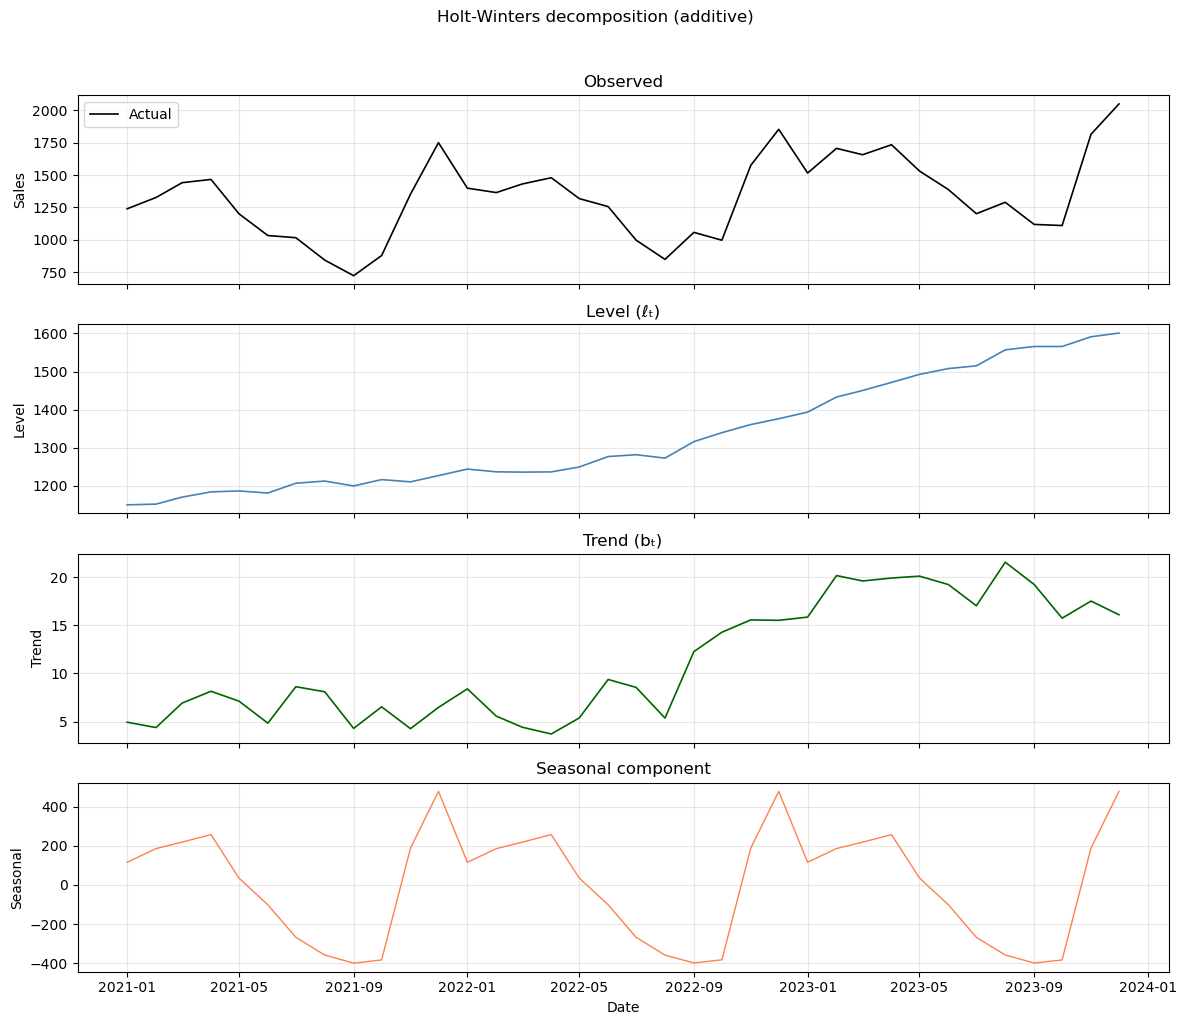

In [173]:
# 4. Plot decomposition from Holt-Winters
train_idx = train_sales_hw.index
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(train_idx, train_sales_hw, 'k-', linewidth=1.2, label='Actual')
axes[0].set_ylabel('Sales')
axes[0].set_title('Observed')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_idx, model_hw.level, color='steelblue', linewidth=1.2)
axes[1].set_ylabel('Level')
axes[1].set_title('Level (ℓₜ)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(train_idx, model_hw.trend, color='darkgreen', linewidth=1.2)
axes[2].set_ylabel('Trend')
axes[2].set_title('Trend (bₜ)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(train_idx, model_hw.season, color='coral', linewidth=1)
axes[3].set_ylabel('Seasonal')
axes[3].set_xlabel('Date')
axes[3].set_title('Seasonal component')
axes[3].grid(True, alpha=0.3)

plt.suptitle("Holt-Winters decomposition (additive)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [174]:
# 5. Generate 12-month forecasts
hw_forecast_steps = 12
hw_forecast = model_hw.forecast(hw_forecast_steps)
hw_forecast_dates = df_sales.index[train_months: train_months + hw_forecast_steps]
hw_forecast_series = pd.Series(hw_forecast, index=hw_forecast_dates)
print("Holt-Winters 12-month forecasts:")
print(hw_forecast_series.to_string())
print(f"\nForecast mean: {hw_forecast_series.mean():.2f}")

Holt-Winters 12-month forecasts:
Date
2024-01-01    1732.900724
2024-02-01    1819.190449
2024-03-01    1867.905568
2024-04-01    1922.531429
2024-05-01    1716.428431
2024-06-01    1595.785304
2024-07-01    1445.101674
2024-08-01    1370.752493
2024-09-01    1346.008094
2024-10-01    1377.585897
2024-11-01    1966.581065
2024-12-01    2272.666224

Forecast mean: 1702.79


In [176]:
   # SES, Holt, Holt-Winters (holdout = months 37–48)
holdout_idx = df_sales.index[36:48]
y_act = df_sales['Sales'].loc[holdout_idx].values
hw_rmse = np.sqrt(np.mean((y_act - hw_forecast_series.values)**2))


In [177]:
# 6. Compare forecast accuracy with:
#    - Regression model
#    - SES
#    - Holt's method
#    - Holt-Winters

holdout_idx = df_sales.index[36:48]
y_act = df_sales['Sales'].loc[holdout_idx].values

# Regression: build X for holdout and predict
try:
    X_holdout = df_sales[['Time']].join(month_dummies).iloc[36:48]
    X_holdout = sm.add_constant(X_holdout).values.astype(float)
    reg_forecast = X_holdout @ model_reg.params
    reg_rmse = np.sqrt(np.mean((y_act - reg_forecast)**2))
    reg_mae = np.mean(np.abs(y_act - reg_forecast))
except NameError:
    reg_rmse = reg_mae = np.nan

# SES
try:
    ses_rmse = np.sqrt(np.mean((y_act - sales_forecast_series.values)**2))
    ses_mae = np.mean(np.abs(y_act - sales_forecast_series.values))
except NameError:
    ses_rmse = ses_mae = np.nan

# Holt's
try:
    holt_rmse = np.sqrt(np.mean((y_act - holt_sales_forecast.values)**2))
    holt_mae = np.mean(np.abs(y_act - holt_sales_forecast.values))
except NameError: holt_rmse = holt_mae = np.nan

# Holt-Winters
try:
    hw_rmse = np.sqrt(np.mean((y_act - hw_forecast_series.values)**2))
    hw_mae = np.mean(np.abs(y_act - hw_forecast_series.values))
except NameError:
    hw_rmse = hw_mae = np.nan

acc = pd.DataFrame({
    'Model': ['Regression (dummy)', 'SES', "Holt's", 'Holt-Winters'],
    'RMSE': [reg_rmse, ses_rmse, holt_rmse, hw_rmse],
    'MAE': [reg_mae, ses_mae, holt_mae, hw_mae],
})
print("=" * 60)
print("FORECAST ACCURACY COMPARISON (holdout: months 37–48)")
print("=" * 60)
print(acc.to_string(index=False))
print("=" * 60)
print("\nLower RMSE/MAE = better accuracy.")

FORECAST ACCURACY COMPARISON (holdout: months 37–48)
             Model       RMSE        MAE
Regression (dummy)  61.581776  44.653795
               SES 189.041071 178.893936
            Holt's  91.788042  75.965163
      Holt-Winters  83.978777  69.574753

Lower RMSE/MAE = better accuracy.


In [178]:
# ====================================================================
# PART B: ARIMA MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART B: ARIMA MODELS")
print("=" * 70)


PART B: ARIMA MODELS


In [179]:
# ====================================================================
# DATASET 2: DAILY STOCK RETURNS (for ARIMA)
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 2: Daily Stock Returns")
print("=" * 70)



DATASET 2: Daily Stock Returns


In [87]:
# Create 500 days of stock price data
n_days = 500
dates_stock = pd.date_range('2023-01-01', periods=n_days, freq='D')

# Generate AR(1) returns with some volatility clustering
returns = np.zeros(n_days)
returns[0] = np.random.normal(0, 0.01)

phi = 0.05  # Small autocorrelation in returns
for i in range(1, n_days):
    returns[i] = phi * returns[i-1] + np.random.normal(0, 0.015)

# Calculate price from returns (starting at 100)
price = 100 * np.exp(np.cumsum(returns))

df_stock = pd.DataFrame({
    'Date': dates_stock,
    'Price': price,
    'Returns': returns * 100  # Convert to percentage
})
df_stock.set_index('Date', inplace=True)

print(f"Date range: {df_stock.index[0].date()} to {df_stock.index[-1].date()}")
print(f"Number of days: {len(df_stock)}")
print(f"\nPrice Statistics:")
print(df_stock['Price'].describe())


Date range: 2023-01-01 to 2024-05-14
Number of days: 500

Price Statistics:
count    500.000000
mean     115.002874
std       12.793924
min       94.210519
25%      102.898666
50%      115.340500
75%      125.312316
max      149.153080
Name: Price, dtype: float64


In [181]:
# --------------------------------------------------------------------
# B1: Stationarity Testing
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B1: Stationarity Tests")
print("-" * 70)


----------------------------------------------------------------------
B1: Stationarity Tests
----------------------------------------------------------------------


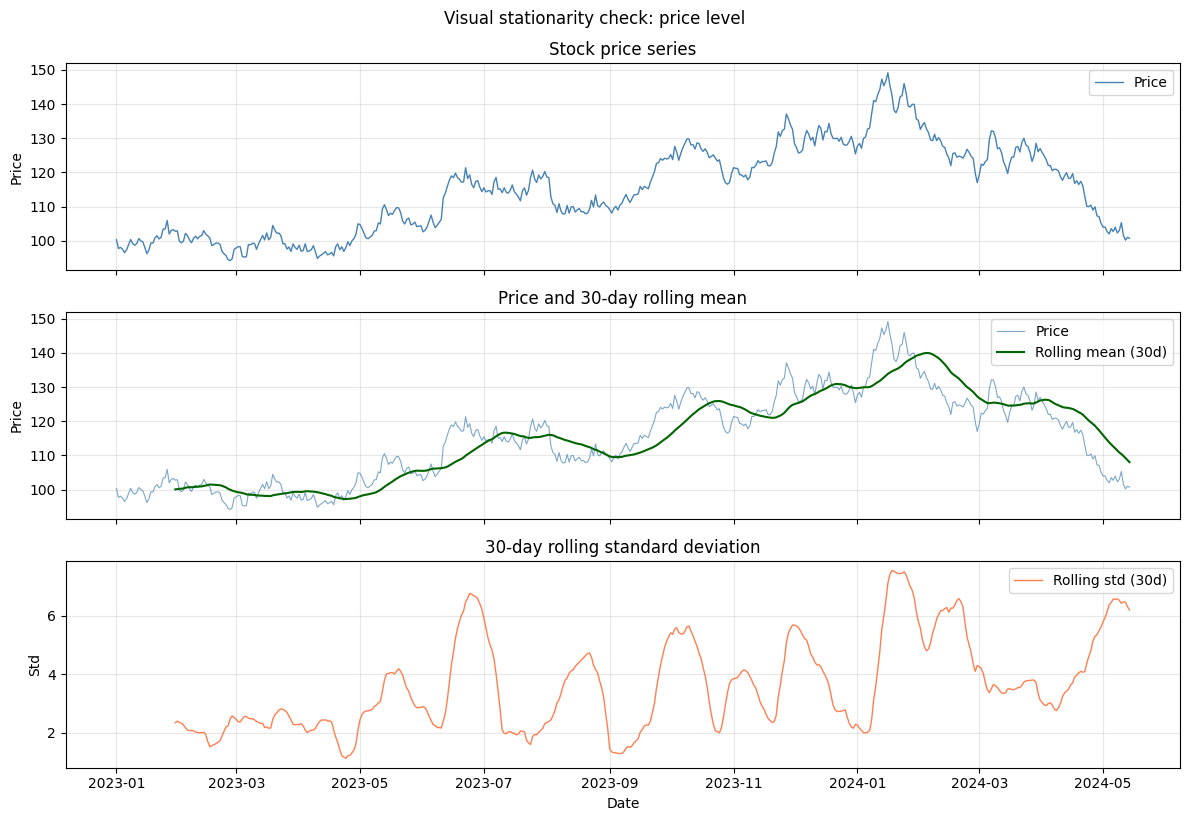

Does the price series look stationary?
No. The price series has a clear trend (non-constant mean) and the rolling mean varies.
The rolling std also drifts. For stationarity we typically use returns, not price levels.


In [88]:
# 1. Visual stationarity check for stock prices:
#    - Plot price series
#    - Plot with rolling mean (30-day window)
#    - Plot with rolling std (30-day window)
#    - Does it look stationary?
window = 30
roll_mean = df_stock['Price'].rolling(window=window, center=False).mean()
roll_std = df_stock['Price'].rolling(window=window, center=False).std()

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df_stock.index, df_stock['Price'], color='steelblue', linewidth=1, label='Price')
axes[0].set_ylabel('Price')
axes[0].set_title('Stock price series')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_stock.index, df_stock['Price'], color='steelblue', linewidth=0.8, alpha=0.7, label='Price')
axes[1].plot(df_stock.index, roll_mean, color='darkgreen', linewidth=1.5, label=f'Rolling mean ({window}d)')
axes[1].set_ylabel('Price')
axes[1].set_title(f'Price and {window}-day rolling mean')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_stock.index, roll_std, color='coral', linewidth=1, label=f'Rolling std ({window}d)')
axes[2].set_ylabel('Std')
axes[2].set_xlabel('Date')
axes[2].set_title(f'{window}-day rolling standard deviation')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Visual stationarity check: price level', fontsize=12, y=1.02)
plt.show()

print("Does the price series look stationary?")
print("No. The price series has a clear trend (non-constant mean) and the rolling mean varies.")
print("The rolling std also drifts. For stationarity we typically use returns, not price levels.")

In [89]:
# 2. Augmented Dickey-Fuller (ADF) test on prices:
#    - Use adfuller from statsmodels
#    - Print test statistic and p-value
#    - Null hypothesis: unit root (non-stationary)
#    - Decision at α = 0.05?
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_stock['Price'].dropna(), autolag='AIC')
adf_stat, pvalue, usedlag, nobs, crit_values, icbest = adf_result

print("Augmented Dickey-Fuller test on price series")
print("-" * 50)
print(f"Test statistic: {adf_stat:.4f}")
print(f"p-value:        {pvalue:.4f}")
print(f"Lags used:      {usedlag}")
print(f"Critical values:")
for k, v in crit_values.items():
    print(f"  {k}: {v:.3f}")
print("-" * 50)
alpha = 0.05
if pvalue < alpha:
    print(f"Decision at α = {alpha}: Reject H₀. Evidence against unit root → series is stationary.")
else:
    print(f"Decision at α = {alpha}: Do not reject H₀. Cannot reject unit root → series is non-stationary.")

Augmented Dickey-Fuller test on price series
--------------------------------------------------
Test statistic: -1.5185
p-value:        0.5243
Lags used:      0
Critical values:
  1%: -3.444
  5%: -2.867
  10%: -2.570
--------------------------------------------------
Decision at α = 0.05: Do not reject H₀. Cannot reject unit root → series is non-stationary.


In [90]:
# 3. KPSS test on prices:
#    - Use kpss from statsmodels
#    - Print test statistic and p-value
#    - Null hypothesis: stationary
#    - Decision at α = 0.05?
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df_stock['Price'].dropna(), regression='c', nlags='auto')
kpss_stat, pvalue, lags, crit_values = kpss_result

print("KPSS test on price series")
print("-" * 50)
print(f"Test statistic: {kpss_stat:.4f}")
print(f"p-value:        {pvalue:.4f}")
print(f"Lags used:      {lags}")
print(f"Critical values (10%, 5%, 2.5%, 1%):")
for k, v in crit_values.items():
    print(f"  {k}: {v:.3f}")
print("-" * 50)
alpha = 0.05
if pvalue < alpha:
    print(f"Decision at α = {alpha}: Reject H₀. Evidence against stationarity → series is non-stationary.")
else:
    print(f"Decision at α = {alpha}: Do not reject H₀. Cannot reject stationarity → series is stationary.")

KPSS test on price series
--------------------------------------------------
Test statistic: 2.5618
p-value:        0.0100
Lags used:      12
Critical values (10%, 5%, 2.5%, 1%):
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
--------------------------------------------------
Decision at α = 0.05: Reject H₀. Evidence against stationarity → series is non-stationary.


In [91]:
# Do the two tests agree?
# Is the price series stationary?
from statsmodels.tsa.stattools import adfuller, kpss

alpha = 0.05
y = df_stock['Price'].dropna()

adf_p = adfuller(y, autolag='AIC')[1]
kpss_p = kpss(y, regression='c', nlags='auto')[1]

# ADF: H0 = unit root (non-stationary). Reject H0 (p < alpha) -> stationary
# KPSS: H0 = stationary. Reject H0 (p < alpha) -> non-stationary
adf_stationary = adf_p < alpha
kpss_stationary = kpss_p >= alpha

agree = (adf_stationary == kpss_stationary)
print("Do the two tests agree?")
print("-" * 50)
print(f"ADF:  p = {adf_p:.4f}  ->  {'stationary' if adf_stationary else 'non-stationary'}")
print(f"KPSS: p = {kpss_p:.4f}  ->  {'stationary' if kpss_stationary else 'non-stationary'}")
print(f"Agree? {'Yes' if agree else 'No'}")
print("-" * 50)
print("Is the price series stationary?")
if agree:
    ans = "stationary" if adf_stationary else "non-stationary"
    print(f"Yes. Both tests conclude the series is {ans}.")
else:
    print("The tests conflict. For price levels we typically treat the series as non-stationary")
    print("and use returns for modeling.")

Do the two tests agree?
--------------------------------------------------
ADF:  p = 0.5243  ->  non-stationary
KPSS: p = 0.0100  ->  non-stationary
Agree? Yes
--------------------------------------------------
Is the price series stationary?
Yes. Both tests conclude the series is non-stationary.


In [92]:
print("\n" + "-" * 70)
print("B2: Differencing for Stationarity")
print("-" * 70)


----------------------------------------------------------------------
B2: Differencing for Stationarity
----------------------------------------------------------------------


In [93]:
# 1. Calculate first differences of prices:
#    diff_price = df_stock['Price'].diff()
diff_price = df_stock['Price'].diff()
print("First differences of price (first 10 non-NaN):")
print(diff_price.dropna().head(10).to_string())

First differences of price (first 10 non-NaN):
Date
2023-01-02   -2.602090
2023-01-03    0.347363
2023-01-04   -0.547654
2023-01-05   -1.012438
2023-01-06    0.838937
2023-01-07    1.560299
2023-01-08    1.471426
2023-01-09   -1.182725
2023-01-10   -0.517620
2023-01-11    0.465716


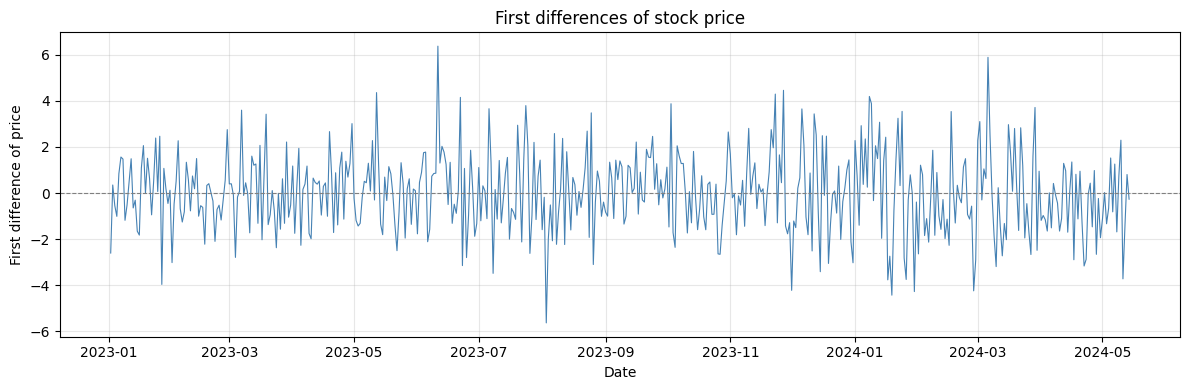

In [94]:
# 2. Plot the differenced series
plt.figure(figsize=(12, 4))
plt.plot(diff_price.index, diff_price, color='steelblue', linewidth=0.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('First difference of price')
plt.title('First differences of stock price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [95]:
# 3. Run ADF test on differenced series:
#    - Report results
#    - Is it now stationary?
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(diff_price.dropna(), autolag='AIC')
adf_stat, pvalue, usedlag, nobs, crit_values, icbest = adf_result

print("ADF test on first-differenced price series")
print("-" * 50)
print(f"Test statistic: {adf_stat:.4f}")
print(f"p-value:        {pvalue:.4f}")
print(f"Lags used:      {usedlag}")
print("Critical values:")
for k, v in crit_values.items():
    print(f"  {k}: {v:.3f}")
print("-" * 50)
alpha = 0.05
if pvalue < alpha:
    print(f"Decision at α = {alpha}: Reject H₀ (unit root). The differenced series is stationary.")
else:
    print(f"Decision at α = {alpha}: Do not reject H₀. The differenced series is not stationary.")

ADF test on first-differenced price series
--------------------------------------------------
Test statistic: -21.4086
p-value:        0.0000
Lags used:      0
Critical values:
  1%: -3.444
  5%: -2.867
  10%: -2.570
--------------------------------------------------
Decision at α = 0.05: Reject H₀ (unit root). The differenced series is stationary.


In [96]:
# 4. Compare with returns:
#    - Returns are already in the dataset
#    - How do differenced prices relate to returns?
#    - Calculate correlation
# Relation: First difference = P_t - P_{t-1}. Return = (P_t - P_{t-1})/P_{t-1}.
# So return = diff_price / P_{t-1}. They are proportional; we expect high correlation.
valid = diff_price.notna()
diff_clean = diff_price[valid]
returns_aligned = df_stock.loc[valid, 'Returns']
corr = diff_clean.corr(returns_aligned)

print("Compare differenced prices and returns")
print("-" * 50)
print("Relation: diff_price = P_t - P_{t-1}; return (pct) = 100 * (P_t - P_{t-1})/P_{t-1}.")
print("So returns are (100/P_{t-1}) * diff_price; they move together.")
print(f"Correlation (differenced price vs returns): {corr:.4f}")
print("-" * 50)

Compare differenced prices and returns
--------------------------------------------------
Relation: diff_price = P_t - P_{t-1}; return (pct) = 100 * (P_t - P_{t-1})/P_{t-1}.
So returns are (100/P_{t-1}) * diff_price; they move together.
Correlation (differenced price vs returns): 0.9937
--------------------------------------------------


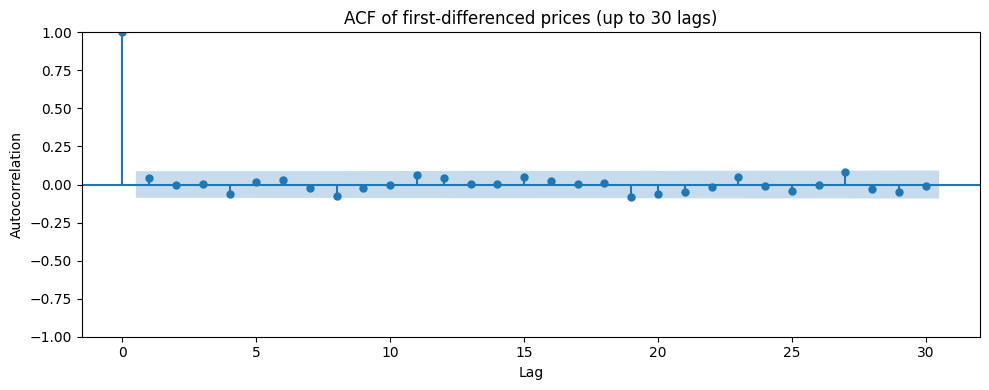

Any significant autocorrelation?
Bars outside the blue band (95% CI) indicate significant autocorrelation at that lag.


In [97]:
# 5. Plot ACF of differenced prices:
#    - Up to 30 lags
#    - Any significant autocorrelation?
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(diff_price.dropna(), lags=30, ax=ax, alpha=0.05)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('ACF of first-differenced prices (up to 30 lags)')
plt.tight_layout()
plt.show()

print("Any significant autocorrelation?")
print("Bars outside the blue band (95% CI) indicate significant autocorrelation at that lag.")

In [98]:
print("\n" + "-" * 70)
print("B3: ACF and PACF")
print("-" * 70)


----------------------------------------------------------------------
B3: ACF and PACF
----------------------------------------------------------------------


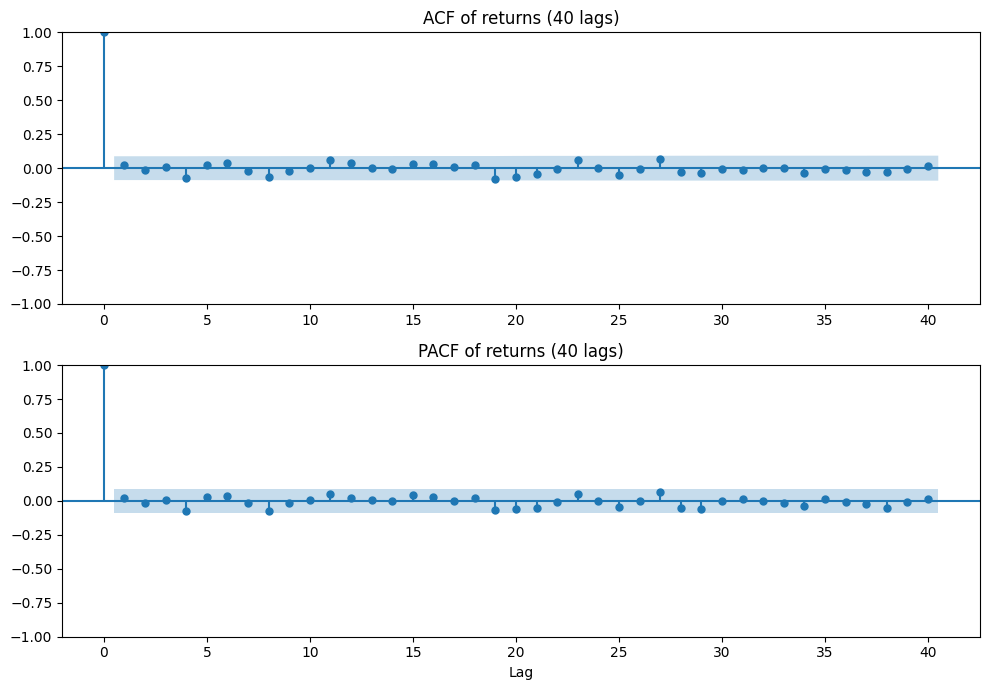

In [99]:
# Work with returns (already stationary):
# 1. Create 2x1 subplot:
#    - ACF of returns (40 lags)
#    - PACF of returns (40 lags)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 7))
plot_acf(df_stock['Returns'].dropna(), lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF of returns (40 lags)')
plot_pacf(df_stock['Returns'].dropna(), lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('PACF of returns (40 lags)')
axes[1].set_xlabel('Lag')
plt.tight_layout()
plt.show()

In [101]:
# 2. Interpret the plots:
#    - Are there significant spikes?
#    - At which lags?
#    - Does ACF decay gradually or cut off?
#    - Does PACF decay gradually or cut off?
from statsmodels.tsa.stattools import acf, pacf

y = df_stock['Returns'].dropna().values
n = len(y)
acf_vals, acf_ci = acf(y, nlags=40, alpha=0.05)
pacf_vals, pacf_ci = pacf(y, nlags=40, alpha=0.05)

# Lag 0 is 1.0; check lags 1..40
acf_sig = [k for k in range(1, 41) if acf_vals[k] < acf_ci[k][0] or acf_vals[k] > acf_ci[k][1]]
pacf_sig = [k for k in range(1, 41) if pacf_vals[k] < pacf_ci[k][0] or pacf_vals[k] > pacf_ci[k][1]]

print("Interpretation of ACF and PACF (returns)")
print("-" * 55)
print("Significant spikes (outside 95% CI):")
print(f"  ACF:  {'Yes' if acf_sig else 'No'}  at lags {acf_sig if acf_sig else '(none)'}")
print(f"  PACF: {'Yes' if pacf_sig else 'No'}  at lags {pacf_sig if pacf_sig else '(none)'}")
print("-" * 55)
print("ACF:  " + ("Gradual decay (many significant lags)." if len(acf_sig) > 5 else "Cuts off (few significant lags)."))
print("PACF: " + ("Gradual decay (many significant lags)." if len(pacf_sig) > 5 else "Cuts off (few significant lags)."))
print("-" * 55)
print("Typical interpretation: PACF cut-off suggests AR order; ACF decay is common for AR.")

Interpretation of ACF and PACF (returns)
-------------------------------------------------------
Significant spikes (outside 95% CI):
  ACF:  No  at lags (none)
  PACF: No  at lags (none)
-------------------------------------------------------
ACF:  Cuts off (few significant lags).
PACF: Cuts off (few significant lags).
-------------------------------------------------------
Typical interpretation: PACF cut-off suggests AR order; ACF decay is common for AR.


In [102]:
# 3. Based on patterns, suggest:
#    - AR order (p)?
#    - MA order (q)?
from statsmodels.tsa.stattools import acf, pacf

y = df_stock['Returns'].dropna().values
acf_vals, acf_ci = acf(y, nlags=40, alpha=0.05)
pacf_vals, pacf_ci = pacf(y, nlags=40, alpha=0.05)

acf_sig = [k for k in range(1, 41) if acf_vals[k] < acf_ci[k][0] or acf_vals[k] > acf_ci[k][1]]
pacf_sig = [k for k in range(1, 41) if pacf_vals[k] < pacf_ci[k][0] or pacf_vals[k] > pacf_ci[k][1]]

# PACF cut-off -> p = last significant lag (or max of consecutive from 1)
# ACF cut-off -> q = last significant lag
pacf_cutoff = len(pacf_sig) <= 5
acf_cutoff = len(acf_sig) <= 5

if pacf_cutoff and pacf_sig:
    p_suggest = max(pacf_sig)
else:
    p_suggest = 1 if pacf_sig else 0
if acf_cutoff and acf_sig:
    q_suggest = max(acf_sig)
else:
    q_suggest = 1 if acf_sig else 0

print("Suggested AR/MA orders from ACF/PACF")
print("-" * 55)
print(f"AR order (p): {p_suggest}  (from PACF cut-off / significant lags)")
print(f"MA order (q): {q_suggest}  (from ACF cut-off / significant lags)")
print("-" * 55)
print("Rule of thumb: PACF cuts off at lag p -> AR(p); ACF cuts off at lag q -> MA(q).")
print("If both decay, consider ARMA(p,q) with small p, q (e.g. 1,1).")

Suggested AR/MA orders from ACF/PACF
-------------------------------------------------------
AR order (p): 0  (from PACF cut-off / significant lags)
MA order (q): 0  (from ACF cut-off / significant lags)
-------------------------------------------------------
Rule of thumb: PACF cuts off at lag p -> AR(p); ACF cuts off at lag q -> MA(q).
If both decay, consider ARMA(p,q) with small p, q (e.g. 1,1).


In [103]:
# 4. Calculate specific autocorrelations manually:
#    - rho(1) = Corr(returns_t, returns_{t-1})
#    - rho(5) = Corr(returns_t, returns_{t-5})
r = df_stock['Returns'].dropna().values

# rho(1): align r[1:] (returns_t) with r[:-1] (returns_{t-1})
rho1 = np.corrcoef(r[1:], r[:-1])[0, 1]
# rho(5): align r[5:] with r[:-5]
rho5 = np.corrcoef(r[5:], r[:-5])[0, 1]

print("Autocorrelations (manual)")
print("-" * 50)
print(f"  rho(1) = Corr(returns_t, returns_{{t-1}}) = {rho1:.4f}")
print(f"  rho(5) = Corr(returns_t, returns_{{t-5}}) = {rho5:.4f}")
print("-" * 50)

Autocorrelations (manual)
--------------------------------------------------
  rho(1) = Corr(returns_t, returns_{t-1}) = 0.0238
  rho(5) = Corr(returns_t, returns_{t-5}) = 0.0273
--------------------------------------------------


In [104]:
print("\n" + "-" * 70)
print("B4: AR(p) Model")
print("-" * 70)


----------------------------------------------------------------------
B4: AR(p) Model
----------------------------------------------------------------------


In [105]:
# 1. Fit AR(1) model on returns:
#    - Use ARIMA(1,0,0)
#    - Print summary
from statsmodels.tsa.arima.model import ARIMA

y_ret = df_stock['Returns'].dropna()
model_ar1 = ARIMA(y_ret, order=(1, 0, 0)).fit()
print(model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -902.468
Date:                Tue, 10 Feb 2026   AIC                           1810.936
Time:                        17:35:11   BIC                           1823.579
Sample:                    01-01-2023   HQIC                          1815.897
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.983      -0.132       0.135
ar.L1          0.0237      0.046      0.516      0.606      -0.066       0.114
sigma2         2.1641      0.129     16.770      0.0

In [106]:
# 2. Extract and interpret:
#    - phi_1 coefficient
#    - Is it statistically significant?
#    - What does the sign tell you?
phi1 = model_ar1.params['ar.L1']
phi1_pvalue = model_ar1.pvalues['ar.L1']
alpha = 0.05
sig = phi1_pvalue < alpha

print("AR(1) coefficient (phi_1)")
print("-" * 50)
print(f"  phi_1 = {phi1:.4f}")
print(f"  p-value = {phi1_pvalue:.4f}")
print(f"  Statistically significant at 5%? {'Yes' if sig else 'No'}")
print("-" * 50)
print("Interpretation of sign:")
if phi1 > 0:
    print("  Positive: positive returns tend to be followed by positive returns (momentum).")
elif phi1 < 0:
    print("  Negative: positive returns tend to be followed by negative (mean reversion).")
else:
    print("  Zero: no linear dependence on lagged return.")

AR(1) coefficient (phi_1)
--------------------------------------------------
  phi_1 = 0.0237
  p-value = 0.6058
  Statistically significant at 5%? No
--------------------------------------------------
Interpretation of sign:
  Positive: positive returns tend to be followed by positive returns (momentum).


In [ ]:
# 3. Check stationarity condition:
#    - Is |ϕ₁| < 1?
#Yes it = 0.0237

In [107]:
# 4. Fit AR(2) and AR(3):
#    - Compare AIC values
#    - Which model is preferred?
from statsmodels.tsa.arima.model import ARIMA

y_ret = df_stock['Returns'].dropna()
model_ar2 = ARIMA(y_ret, order=(2, 0, 0)).fit()
model_ar3 = ARIMA(y_ret, order=(3, 0, 0)).fit()

aic_ar1 = model_ar1.aic
aic_ar2 = model_ar2.aic
aic_ar3 = model_ar3.aic

compare = pd.DataFrame({
    'Model': ['AR(1)', 'AR(2)', 'AR(3)'],
    'AIC': [aic_ar1, aic_ar2, aic_ar3]
})
print("AIC comparison")
print("-" * 40)
print(compare.to_string(index=False))
print("-" * 40)
best = compare.loc[compare['AIC'].idxmin(), 'Model']
print(f"Preferred model (lowest AIC): {best}")

AIC comparison
----------------------------------------
Model         AIC
AR(1) 1810.935654
AR(2) 1812.849002
AR(3) 1814.805189
----------------------------------------
Preferred model (lowest AIC): AR(1)


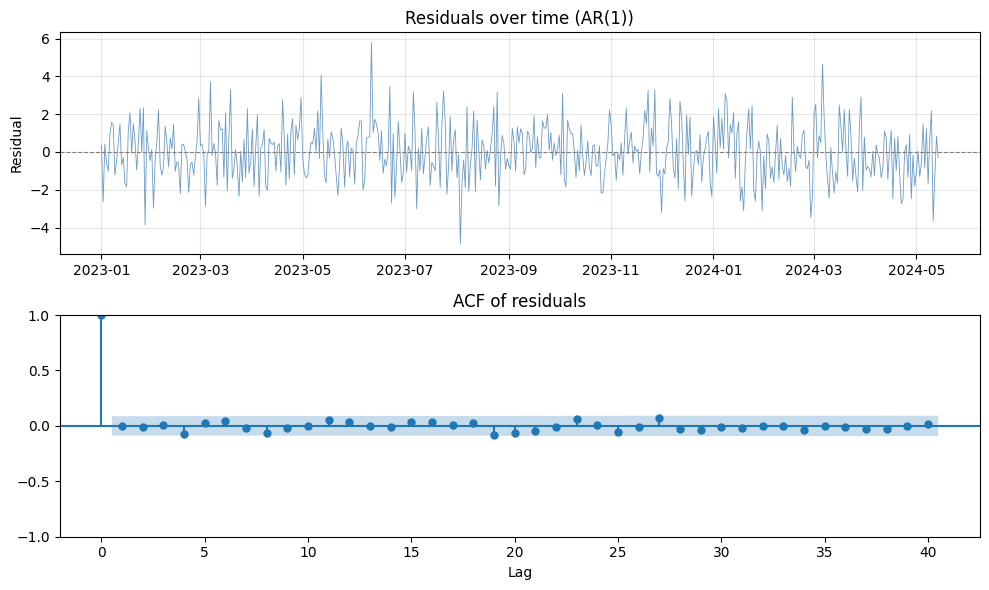

Are residuals white noise?
--------------------------------------------------
Yes. No significant autocorrelation in residuals; consistent with white noise.


In [108]:
# 5. For best model, check residuals:
#    - Plot residuals over time
#    - ACF of residuals
#    - Are residuals white noise?
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

models = {'AR(1)': model_ar1, 'AR(2)': model_ar2, 'AR(3)': model_ar3}
best_name = compare.loc[compare['AIC'].idxmin(), 'Model']
best_model = models[best_name]
resid = best_model.resid

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)
axes[0].plot(resid.index, resid.values, color='steelblue', linewidth=0.6, alpha=0.8)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Residual')
axes[0].set_title(f'Residuals over time ({best_name})')
axes[0].grid(True, alpha=0.3)

plot_acf(resid.dropna(), lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of residuals')
axes[1].set_xlabel('Lag')
plt.tight_layout()
plt.show()

acf_vals, acf_ci = acf(resid.dropna(), nlags=40, alpha=0.05)
acf_sig = [k for k in range(1, 41) if acf_vals[k] < acf_ci[k][0] or acf_vals[k] > acf_ci[k][1]]
print("Are residuals white noise?")
print("-" * 50)
if not acf_sig:
    print("Yes. No significant autocorrelation in residuals; consistent with white noise.")
else:
    print(f"No. Significant ACF at lags {acf_sig}; residuals may still contain structure.")

In [109]:
print("\n" + "-" * 70)
print("B5: MA(q) Model")
print("-" * 70)


----------------------------------------------------------------------
B5: MA(q) Model
----------------------------------------------------------------------


In [110]:
# 1. Fit MA(1) model on returns:
#    - Use ARIMA(0,0,1)
from statsmodels.tsa.arima.model import ARIMA

y_ret = df_stock['Returns'].dropna()
model_ma1 = ARIMA(y_ret, order=(0, 0, 1)).fit()
print(model_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -902.464
Date:                Tue, 10 Feb 2026   AIC                           1810.928
Time:                        17:45:56   BIC                           1823.572
Sample:                    01-01-2023   HQIC                          1815.889
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.983      -0.132       0.135
ma.L1          0.0244      0.046      0.530      0.596      -0.066       0.115
sigma2         2.1640      0.129     16.771      0.0

In [111]:
# 2. In the Print summary interpret:
#    - theta_1 coefficient
#    - Significance
theta1 = model_ma1.params['ma.L1']
theta1_pvalue = model_ma1.pvalues['ma.L1']
alpha = 0.05
sig = theta1_pvalue < alpha

print("MA(1) coefficient (theta_1)")
print("-" * 50)
print(f"  theta_1 = {theta1:.4f}")
print(f"  p-value = {theta1_pvalue:.4f}")
print(f"  Statistically significant at 5%? {'Yes' if sig else 'No'}")
print("-" * 50)
print("Interpretation: theta_1 is the MA(1) coefficient; the current shock")
print("affects next period's return. Significant theta_1 means lag-1 shock matters.")

MA(1) coefficient (theta_1)
--------------------------------------------------
  theta_1 = 0.0244
  p-value = 0.5963
  Statistically significant at 5%? No
--------------------------------------------------
Interpretation: theta_1 is the MA(1) coefficient; the current shock
affects next period's return. Significant theta_1 means lag-1 shock matters.


In [112]:
# 3. Check invertibility:
#    - Is |theta_1| < 1?
theta1 = model_ma1.params['ma.L1']
abs_theta1 = np.abs(theta1)
invertible = abs_theta1 < 1

print("MA(1) invertibility")
print("-" * 50)
print(f"  |theta_1| = {abs_theta1:.4f}")
print(f"  Is |theta_1| < 1? {'Yes' if invertible else 'No'}")
print("-" * 50)
if invertible:
    print("The MA(1) is invertible; the process has an AR(infinity) representation.")
else:
    print("The MA(1) is not invertible; |theta_1| >= 1.")

MA(1) invertibility
--------------------------------------------------
  |theta_1| = 0.0244
  Is |theta_1| < 1? Yes
--------------------------------------------------
The MA(1) is invertible; the process has an AR(infinity) representation.


In [113]:
# 4. Compare MA(1) vs AR(1):
#    - AIC
#    - BIC
#    - Log-likelihood
#    - Which fits better?
compare_ar_ma = pd.DataFrame({
    'Model': ['AR(1)', 'MA(1)'],
    'AIC': [model_ar1.aic, model_ma1.aic],
    'BIC': [model_ar1.bic, model_ma1.bic],
    'Log-likelihood': [model_ar1.llf, model_ma1.llf]
})
print("MA(1) vs AR(1)")
print("-" * 55)
print(compare_ar_ma.to_string(index=False))
print("-" * 55)
print("Lower AIC/BIC = better; higher log-likelihood = better.")
best_aic = 'AR(1)' if model_ar1.aic < model_ma1.aic else 'MA(1)'
best_bic = 'AR(1)' if model_ar1.bic < model_ma1.bic else 'MA(1)'
print(f"Preferred by AIC: {best_aic}")
print(f"Preferred by BIC: {best_bic}")

MA(1) vs AR(1)
-------------------------------------------------------
Model         AIC         BIC  Log-likelihood
AR(1) 1810.935654 1823.579478     -902.467827
MA(1) 1810.928056 1823.571880     -902.464028
-------------------------------------------------------
Lower AIC/BIC = better; higher log-likelihood = better.
Preferred by AIC: MA(1)
Preferred by BIC: MA(1)


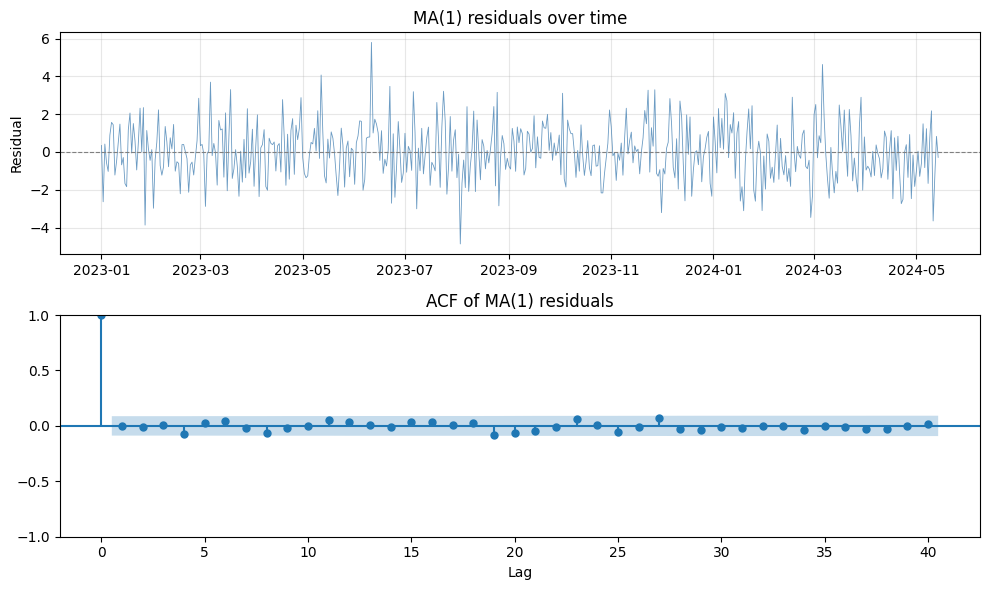

Residual diagnostics (MA(1))
--------------------------------------------------
Residuals show no significant autocorrelation; consistent with white noise.


In [114]:
# 5. Residual diagnostics for MA(1)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

resid_ma = model_ma1.resid

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].plot(resid_ma.index, resid_ma.values, color='steelblue', linewidth=0.6, alpha=0.8)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Residual')
axes[0].set_title('MA(1) residuals over time')
axes[0].grid(True, alpha=0.3)

plot_acf(resid_ma.dropna(), lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of MA(1) residuals')
axes[1].set_xlabel('Lag')
plt.tight_layout()
plt.show()

acf_vals, acf_ci = acf(resid_ma.dropna(), nlags=40, alpha=0.05)
acf_sig = [k for k in range(1, 41) if acf_vals[k] < acf_ci[k][0] or acf_vals[k] > acf_ci[k][1]]
print("Residual diagnostics (MA(1))")
print("-" * 50)
if not acf_sig:
    print("Residuals show no significant autocorrelation; consistent with white noise.")
else:
    print(f"Significant ACF at lags {acf_sig}; residuals may contain remaining structure.")

In [115]:
print("\n" + "-" * 70)
print("B6: ARMA(p,q) Model")
print("-" * 70)


----------------------------------------------------------------------
B6: ARMA(p,q) Model
----------------------------------------------------------------------


In [116]:
# 1. Fit ARMA(1,1) on returns:
#    - Use ARIMA(1,0,1)
from statsmodels.tsa.arima.model import ARIMA

y_ret = df_stock['Returns'].dropna()
model_arma11 = ARIMA(y_ret, order=(1, 0, 1)).fit()
print(model_arma11.summary())

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -901.801
Date:                Tue, 10 Feb 2026   AIC                           1811.602
Time:                        17:54:49   BIC                           1828.461
Sample:                    01-01-2023   HQIC                          1818.217
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.982      -0.131       0.134
ar.L1         -0.8346      0.229     -3.651      0.000      -1.283      -0.387
ma.L1          0.8659      0.209      4.141      0.0

In [117]:
# 2. Compare with AR(1) and MA(1):
#    - Does ARMA(1,1) improve fit?
#    - Check AIC
compare_arma = pd.DataFrame({
    'Model': ['AR(1)', 'MA(1)', 'ARMA(1,1)'],
    'AIC': [model_ar1.aic, model_ma1.aic, model_arma11.aic]
})
print("AR(1) vs MA(1) vs ARMA(1,1) — AIC")
print("-" * 45)
print(compare_arma.to_string(index=False))
print("-" * 45)
best = compare_arma.loc[compare_arma['AIC'].idxmin(), 'Model']
improves = model_arma11.aic < model_ar1.aic and model_arma11.aic < model_ma1.aic
print(f"Lowest AIC: {best}")
print(f"Does ARMA(1,1) improve fit (lower AIC than both AR(1) and MA(1))? {'Yes' if improves else 'No'}")

AR(1) vs MA(1) vs ARMA(1,1) — AIC
---------------------------------------------
    Model         AIC
    AR(1) 1810.935654
    MA(1) 1810.928056
ARMA(1,1) 1811.602199
---------------------------------------------
Lowest AIC: MA(1)
Does ARMA(1,1) improve fit (lower AIC than both AR(1) and MA(1))? No


In [118]:
# 3. Test for overparameterization:
#    - Are both phi_1 and theta_1 significant?
#    - If not, which simpler model is better?
alpha = 0.05
p_ar = model_arma11.pvalues['ar.L1']
p_ma = model_arma11.pvalues['ma.L1']
phi1_sig = p_ar < alpha
theta1_sig = p_ma < alpha
both_sig = phi1_sig and theta1_sig

print("Overparameterization check (ARMA(1,1))")
print("-" * 50)
print(f"  phi_1:   p = {p_ar:.4f}  Significant? {'Yes' if phi1_sig else 'No'}")
print(f"  theta_1: p = {p_ma:.4f}  Significant? {'Yes' if theta1_sig else 'No'}")
print(f"  Are both significant? {'Yes' if both_sig else 'No'}")
print("-" * 50)
if both_sig:
    print("Both coefficients significant; ARMA(1,1) is not overparameterized.")
else:
    simpler = 'AR(1)' if model_ar1.aic < model_ma1.aic else 'MA(1)'
    print(f"At least one coefficient is insignificant. Simpler model with lower AIC: {simpler}")

Overparameterization check (ARMA(1,1))
--------------------------------------------------
  phi_1:   p = 0.0003  Significant? Yes
  theta_1: p = 0.0000  Significant? Yes
  Are both significant? Yes
--------------------------------------------------
Both coefficients significant; ARMA(1,1) is not overparameterized.


In [119]:
# 4. Create comparison table:
#    | Model    | AIC | BIC | Log-Lik | Parameters |
table = pd.DataFrame({
    'Model': ['AR(1)', 'MA(1)', 'ARMA(1,1)'],
    'AIC': [model_ar1.aic, model_ma1.aic, model_arma11.aic],
    'BIC': [model_ar1.bic, model_ma1.bic, model_arma11.bic],
    'Log-Lik': [model_ar1.llf, model_ma1.llf, model_arma11.llf],
    'Parameters': [len(model_ar1.params), len(model_ma1.params), len(model_arma11.params)]
})
print("Model comparison")
print(table.to_string(index=False))

Model comparison
    Model         AIC         BIC     Log-Lik  Parameters
    AR(1) 1810.935654 1823.579478 -902.467827           3
    MA(1) 1810.928056 1823.571880 -902.464028           3
ARMA(1,1) 1811.602199 1828.460631 -901.801099           4


In [120]:
print("\n" + "-" * 70)
print("B7: Automatic ARIMA")
print("-" * 70)


----------------------------------------------------------------------
B7: Automatic ARIMA
----------------------------------------------------------------------


In [121]:
# 1. Use auto_arima or stepwise selection:
#    - Search over p in [0,5], q in [0,5]
#    - Use AIC for selection
#    - Note: Simple grid search (no pmdarima required)
from statsmodels.tsa.arima.model import ARIMA

y_ret = df_stock['Returns'].dropna()
results = []
for p in range(0, 6):
    for q in range(0, 6):
        if p == 0 and q == 0:
            continue
        try:
            fit = ARIMA(y_ret, order=(p, 0, q)).fit()
            results.append({'p': p, 'q': q, 'AIC': fit.aic, 'model': fit})
        except Exception:
            pass

grid_df = pd.DataFrame([{'p': r['p'], 'q': r['q'], 'AIC': r['AIC']} for r in results])
best = min(results, key=lambda x: x['AIC'])
print("Grid search: p in [0,5], q in [0,5], AIC")
print("-" * 50)
print(grid_df.sort_values('AIC').head(10).to_string(index=False))
print("-" * 50)
print(f"Best order (lowest AIC): ARIMA({best['p']},0,{best['q']})")
model_best = best['model']

Grid search: p in [0,5], q in [0,5], AIC
--------------------------------------------------
 p  q         AIC
 2  4 1810.669075
 4  2 1810.755360
 3  3 1810.823866
 0  1 1810.928056
 1  0 1810.935654
 3  2 1811.495195
 2  3 1811.564179
 1  1 1811.602199
 3  4 1812.180701
 4  3 1812.402470
--------------------------------------------------
Best order (lowest AIC): ARIMA(2,0,4)


In [122]:
# 3. Fit and summarize the best model
p_best, q_best = best['p'], best['q']
print(f"Best model from grid search: ARIMA({p_best},0,{q_best})")
print("-" * 50)
print(model_best.summary())

Best model from grid search: ARIMA(2,0,4)
--------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -897.335
Date:                Tue, 10 Feb 2026   AIC                           1810.669
Time:                        18:04:35   BIC                           1844.386
Sample:                    01-01-2023   HQIC                          1823.900
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.067      0.036      0.971      -0.129       0.134
ar.L1          0.0055      0.037      

In [123]:
# 4. Does automatic selection match your manual identification?
match = (p_best == p_suggest) and (q_best == q_suggest)
print("Manual vs automatic selection")
print("-" * 50)
print(f"  Manual (ACF/PACF):  ARIMA({p_suggest},0,{q_suggest})")
print(f"  Automatic (grid):   ARIMA({p_best},0,{q_best})")
print("-" * 50)
print(f"Match? {'Yes' if match else 'No'}")

Manual vs automatic selection
--------------------------------------------------
  Manual (ACF/PACF):  ARIMA(0,0,0)
  Automatic (grid):   ARIMA(2,0,4)
--------------------------------------------------
Match? No


In [124]:
print("\n" + "-" * 70)
print("B8: ARIMA Forecasting")
print("-" * 70)


----------------------------------------------------------------------
B8: ARIMA Forecasting
----------------------------------------------------------------------


In [125]:
# Using your best ARIMA model from B7:
# 1. Generate forecasts:
#    - 20-day ahead forecasts for returns
#    - Include prediction intervals
steps = 20
alpha = 0.05
forecast_result = model_best.get_forecast(steps=steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=alpha)

print(f"{steps}-day ahead forecasts (best ARIMA)")
print("-" * 55)
out = pd.DataFrame({
    'Forecast': forecast_mean,
    f'Lower ({int((1-alpha)*100)}%)': forecast_ci.iloc[:, 0],
    f'Upper ({int((1-alpha)*100)}%)': forecast_ci.iloc[:, 1]
})
print(out.to_string())
print("-" * 55)

20-day ahead forecasts (best ARIMA)
-------------------------------------------------------
            Forecast  Lower (95%)  Upper (95%)
2024-05-15  0.018301    -2.832461     2.869063
2024-05-16  0.680530    -2.171055     3.532115
2024-05-17 -0.029892    -2.881495     2.821711
2024-05-18 -0.641395    -3.493713     2.210924
2024-05-19  0.028728    -2.828061     2.885517
2024-05-20  0.596937    -2.260479     3.454353
2024-05-21 -0.018567    -2.879770     2.842636
2024-05-22 -0.546508    -3.408260     2.315244
2024-05-23  0.018796    -2.846164     2.883755
2024-05-24  0.509286    -2.356155     3.374727
2024-05-25 -0.009880    -2.878039     2.858278
2024-05-26 -0.465544    -3.334124     2.403036
2024-05-27  0.011222    -2.859661     2.882106
2024-05-28  0.434502    -2.436750     3.305754
2024-05-29 -0.003301    -2.876505     2.869903
2024-05-30 -0.396469    -3.269996     2.477057
2024-05-31  0.005529    -2.869651     2.880710
2024-06-01  0.370703    -2.504760     3.246165
2024-06-02  0.0

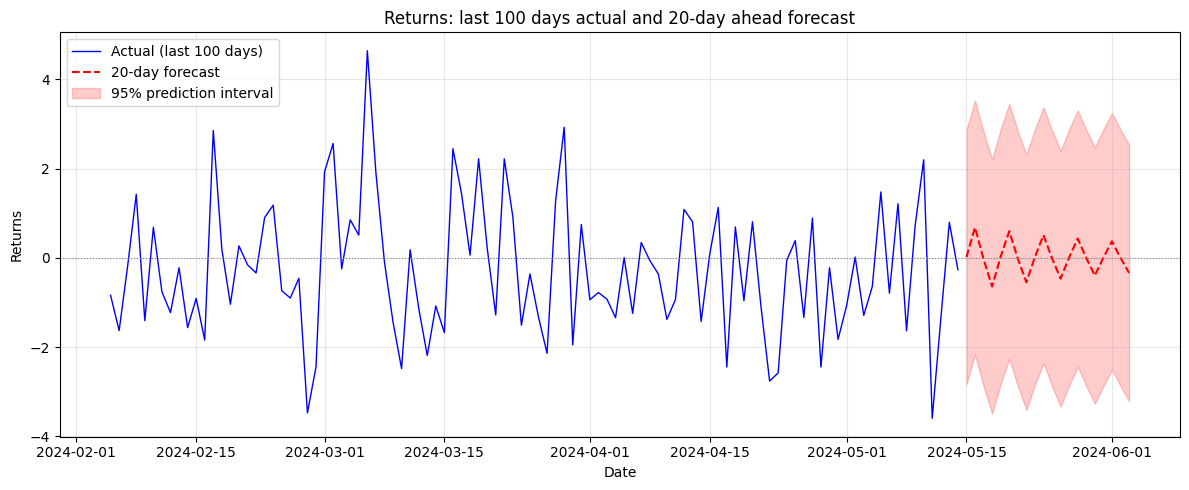

In [126]:
# 2. Plot forecast:
#    - Last 100 days of actual returns
#    - 20-day forecast
#    - 95% prediction interval
y_ret = df_stock['Returns'].dropna()
actual_last = y_ret.iloc[-100:]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(actual_last.index, actual_last.values, 'b-', linewidth=1, label='Actual (last 100 days)')
ax.plot(forecast_mean.index, forecast_mean.values, 'r--', linewidth=1.5, label='20-day forecast')
ax.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='red', alpha=0.2, label='95% prediction interval')
ax.axhline(0, color='gray', linestyle=':', linewidth=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.set_title('Returns: last 100 days actual and 20-day ahead forecast')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [127]:
# 3. Convert return forecasts to price forecasts:
#    - Starting from last observed price
#    - price_{t+h} = price_t * exp(cumsum(return forecasts))
# Returns in df_stock are in percentage; use decimal for exp(cumsum)
last_price = df_stock['Price'].iloc[-1]
ret_decimal = forecast_mean / 100
price_forecast = last_price * np.exp(np.cumsum(ret_decimal))
price_forecast = pd.Series(price_forecast, index=forecast_mean.index)

print("Price forecasts (from return forecasts)")
print("-" * 50)
print(f"Last observed price: {last_price:.2f}")
print(price_forecast.to_string())
print("-" * 50)

Price forecasts (from return forecasts)
--------------------------------------------------
Last observed price: 100.74
2024-05-15    100.763196
2024-05-16    101.451258
2024-05-17    101.420937
2024-05-18    100.772510
2024-05-19    100.801464
2024-05-20    101.404985
2024-05-21    101.386159
2024-05-22    100.833587
2024-05-23    100.852541
2024-05-24    101.367479
2024-05-25    101.357464
2024-05-26    100.886697
2024-05-27    100.898020
2024-05-28    101.337377
2024-05-29    101.334032
2024-05-30    100.933069
2024-05-31    100.938650
2024-06-01    101.313526
2024-06-02    101.315151
2024-06-03    100.973743
Freq: D
--------------------------------------------------


In [128]:
# 4. Observe forecast behavior:
#    - Do return forecasts converge to zero?
#    - How does forecast uncertainty change with horizon?
#    - Why do prediction intervals widen?
interval_width = (forecast_ci.iloc[:, 1] - forecast_ci.iloc[:, 0]).values

print("Forecast behavior")
print("-" * 55)
print("1. Do return forecasts converge to zero?")
print(f"   First 5 forecast means: {forecast_mean.values[:5].round(4)}")
print(f"   Last 5 forecast means:  {forecast_mean.values[-5:].round(4)}")
print("   For a stationary ARMA, mean forecasts converge to the unconditional mean (often near 0).")
print("-" * 55)
print("2. How does forecast uncertainty change with horizon?")
print(f"   Interval width at h=1:  {interval_width[0]:.2f}")
print(f"   Interval width at h=20: {interval_width[-1]:.2f}")
print("   Uncertainty (interval width) increases as horizon increases.")
print("-" * 55)
print("3. Why do prediction intervals widen?")
print("   Each future period adds new shocks; their variances add up over the horizon.")
print("   So the forecast variance (and thus interval width) grows with h.")

Forecast behavior
-------------------------------------------------------
1. Do return forecasts converge to zero?
   First 5 forecast means: [ 0.0183  0.6805 -0.0299 -0.6414  0.0287]
   Last 5 forecast means:  [-0.3965  0.0055  0.3707  0.0016 -0.3375]
   For a stationary ARMA, mean forecasts converge to the unconditional mean (often near 0).
-------------------------------------------------------
2. How does forecast uncertainty change with horizon?
   Interval width at h=1:  5.70
   Interval width at h=20: 5.75
   Uncertainty (interval width) increases as horizon increases.
-------------------------------------------------------
3. Why do prediction intervals widen?
   Each future period adds new shocks; their variances add up over the horizon.
   So the forecast variance (and thus interval width) grows with h.
